<a href="https://colab.research.google.com/github/trandangtrungduc/BasicDeepLearningTask/blob/main/Author_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  **TABLE OF CONTENTS**

---

## 1. Exploratory Data Analysis and pre-process data

## 2. Bag of word including GridSearchCV

## 3. Term Frequency-Inverse Document Frequency

## 4. Word2vec

## 5. Recurrent Neural Networks

## 6. Unsupervised technique

## 7. Latent Dirichlet Allocation, Latent Semantic Analysis, Non-Negative Matrix Factorization





---


## **1. Exploratory Data Analysis and pre-process data** 




### 1.1 Import necessary librabries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus.reader.plaintext import PlaintextCorpusReader
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer

from tensorflow.keras.layers import LSTM, Embedding, Input, Flatten, Dense, Dropout
from keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential

from gensim.models import Word2Vec, KeyedVectors, FastText
from gensim.summarization import keywords

import requests
import os
import pandas as pd
import numpy as np
import spacy
import re
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

from sklearn import metrics
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import InterclusterDistance
from yellowbrick.cluster import KElbowVisualizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# Dictionary of novels by author
Novels = [ 
          {'author': 'Ivar Jorgensen', 'url':'https://www.gutenberg.org/files/65726/65726-0.txt'},
          {'author': 'S. M. Tenneshaw', 'url':'https://www.gutenberg.org/files/65283/65283-0.txt'},
          {'author': 'L. T. Meade', 'url':'https://www.gutenberg.org/files/66110/66110-0.txt'},
          {'author': 'Jane Austen', 'url': 'http://www.gutenberg.org/files/1212/1212-0.txt'},
          {'author': 'Jane Austen', 'url': 'http://www.gutenberg.org/files/158/158-0.txt'},
          {'author': 'Fyodor Dostoevsky', 'url': 'http://www.gutenberg.org/files/2554/2554-0.txt'},
          {'author': 'Fyodor Dostoevsky', 'url': 'http://www.gutenberg.org/files/36034/36034-8.txt'},
          {'author': 'Emily Bronte', 'url': 'http://www.gutenberg.org/files/768/768-0.txt'},
          {'author': 'Charlotte Bronte', 'url': 'http://www.gutenberg.org/files/54254/54254.txt'},
          {'author': 'Anne Bronte', 'url': 'http://www.gutenberg.org/files/767/767-0.txt'},
          {'author': 'Edith Rickert & Gleb Botkin', 'url': 'http://www.gutenberg.org/files/59994/59994-0.txt'},
          {'author': 'Ethel M. Dell', 'url': 'http://www.gutenberg.org/files/43069/43069-0.txt' },
          {'author': 'Ethel M. Dell', 'url': 'http://www.gutenberg.org/files/12484/12484-8.txt'},
          {'author': 'Bell AKA Bronte Sisters', 'url': 'http://www.gutenberg.org/files/1019/1019-0.txt'},
          {'author': 'Various', 'url': 'http://www.gutenberg.org/files/29390/29390.txt'}   
         ]

In [ ]:
PATH = '/content/drive/MyDrive/Data/Author Classification/Novels'
i = 0
for novel in Novels:
  # Get content
  content = requests.get(novel['url']).text
  # Define the folder
  folder = PATH + f'/{novel["author"]}/'
  if not os.path.exists(folder):
      os.makedirs(folder)
  # Save the text
  with open(folder + f'novel{i}.txt', 'wb') as f:
      f.write(str(content).encode())
  i += 1

### 1.2 Exploratory Data Analysis

In [ ]:
# File location
DOC_PATTERN = r'.*\.txt'
novel_corpus = PlaintextCorpusReader(PATH, DOC_PATTERN)

In [ ]:
# Function for showing information statistics of corpus
def Corpus_Statistic(novel_corpus):
  print("NOVEL CORPUS STATISTICS")
  print(' - Number of Documents: ' + str(len(novel_corpus.fileids())))
  print(' - Number of Paragraphs: ' + str(len(novel_corpus.paras())))
  print(' - Number of Sentences: ' + str(len(novel_corpus.sents())))
  print(' - Number of Words: ' + str(len(novel_corpus.words())))
  print(' - Vocabulary: ' + str(len(set(w.lower() for w in novel_corpus.words()))))
  print(' - Average characters per word: ' + str(round(len(novel_corpus.raw())/len(novel_corpus.words()), 1)))
  print(' - Average words per sentence: '+ str(round(len(novel_corpus.words())/len(novel_corpus.sents()), 1)))

In [ ]:
Corpus_Statistic(novel_corpus)

NOVEL CORPUS STATISTICS
 - Number of Documents: 15
 - Number of Paragraphs: 28835
 - Number of Sentences: 84385
 - Number of Words: 1576767
 - Vocabulary: 27943
 - Average characters per word: 4.6
 - Average words per sentence: 18.7


In [ ]:
# Name of text file
print("File structure saved by author's name")
novel_corpus.fileids()

File structure saved by author's name


['Anne Bronte/novel9.txt',
 'Bell AKA Bronte Sisters/novel13.txt',
 'Charlotte Bronte/novel8.txt',
 'Edith Rickert & Gleb Botkin/novel10.txt',
 'Emily Bronte/novel7.txt',
 'Ethel M. Dell/novel11.txt',
 'Ethel M. Dell/novel12.txt',
 'Fyodor Dostoevsky/novel5.txt',
 'Fyodor Dostoevsky/novel6.txt',
 'Ivar Jorgensen/novel0.txt',
 'Jane Austen/novel3.txt',
 'Jane Austen/novel4.txt',
 'L. T. Meade/novel2.txt',
 'S. M. Tenneshaw/novel1.txt',
 'Various/novel14.txt']

In [ ]:
# The paragraph introduction
novel_corpus.paras(fileids=['Anne Bronte/novel9.txt'])

[[['ï', '»¿', 'The', 'Project', 'Gutenberg', 'eBook', 'of', 'Agnes', 'Grey', ',', 'by', 'Anne', 'BrontÃ', '«']], [['This', 'eBook', 'is', 'for', 'the', 'use', 'of', 'anyone', 'anywhere', 'in', 'the', 'United', 'States', 'and', 'most', 'other', 'parts', 'of', 'the', 'world', 'at', 'no', 'cost', 'and', 'with', 'almost', 'no', 'restrictions', 'whatsoever', '.'], ['You', 'may', 'copy', 'it', ',', 'give', 'it', 'away', 'or', 're', '-', 'use', 'it', 'under', 'the', 'terms', 'of', 'the', 'Project', 'Gutenberg', 'License', 'included', 'with', 'this', 'eBook', 'or', 'online', 'at', 'www', '.', 'gutenberg', '.', 'org', '.'], ['If', 'you', 'are', 'not', 'located', 'in', 'the', 'United', 'States', ',', 'you', 'will', 'have', 'to', 'check', 'the', 'laws', 'of', 'the', 'country', 'where', 'you', 'are', 'located', 'before', 'using', 'this', 'eBook', '.']], ...]

> The text files contains unwanted characters and need to be ridded of them.

#### 1.2.1 Beginning of Novels

In [ ]:
# Character encoder
commonpara = novel_corpus.paras(fileids=['Anne Bronte/novel9.txt'])[6]
print(commonpara[0][4]+commonpara[0][5]+commonpara[0][6])

UTF-8


In [ ]:
# Novels with this same encoding
character_UTF8_ids = []
for fileid in novel_corpus.fileids():
  paras_of_fileid = novel_corpus.paras(fileids=fileid)
  for para in paras_of_fileid:
    if para == commonpara:
      character_UTF8_ids.append(fileid)
character_UTF8_ids

['Anne Bronte/novel9.txt',
 'Bell AKA Bronte Sisters/novel13.txt',
 'Edith Rickert & Gleb Botkin/novel10.txt',
 'Emily Bronte/novel7.txt',
 'Fyodor Dostoevsky/novel5.txt',
 'Ivar Jorgensen/novel0.txt',
 'Jane Austen/novel3.txt',
 'Jane Austen/novel4.txt',
 'L. T. Meade/novel2.txt',
 'S. M. Tenneshaw/novel1.txt']

In [ ]:
# Title
title = novel_corpus.paras(fileids=['Anne Bronte/novel9.txt'])[2][0]
title

['Title', ':', 'Agnes', 'Grey']

In [ ]:
# Get the last paragraph of the text  except for the introduction
novel_corpus.paras(fileids=['Anne Bronte/novel9.txt'])[8:13]

[[['***',
   'START',
   'OF',
   'THE',
   'PROJECT',
   'GUTENBERG',
   'EBOOK',
   'AGNES',
   'GREY',
   '***']],
 [['Agnes', 'Grey', 'A', 'NOVEL', ',']],
 [['by', 'ACTON', 'BELL', '.']],
 [['LONDON',
   ':',
   'THOMAS',
   'CAUTLEY',
   'NEWBY',
   ',',
   'PUBLISHER',
   ',',
   '72',
   ',',
   'MORTIMER',
   'ST',
   '.,',
   'CAVENDISH',
   'SQ',
   '.']],
 [['1847', '.']]]

In [ ]:
# Save index of the first paragraph after the sentence *** START OF PROJECT GUTENGBERG *** 
fileids = []
para_index = []  # List of index of the first paragraphs according to the novel order of fileids
common_sentence = ['***', 'START', 'OF', 'PROJECT','GUTENBERG',]
for fileid in novel_corpus.fileids():
  paras_of_fileid = novel_corpus.paras(fileid)
  for para in paras_of_fileid:
    if set(common_sentence).issubset(para[0]):
      fileids.append(fileid)
      para_index.append(paras_of_fileid.index(para)+1)   

In [ ]:
# Show results
i = 0
for fileid in fileids:
  print(novel_corpus.paras(fileid)[para_index[i]])
  i += 1

[['Agnes', 'Grey', 'A', 'NOVEL', ',']]
[['POEMS']]
[['Produced', 'by', 'David', 'Edwards', ',', 'Mary', 'Glenn', 'Krause', ',', 'Eleni', 'Christofaki', 'and', 'the', 'Online', 'Distributed', 'Proofreading', 'Team', 'at', 'http', '://', 'www', '.', 'pgdp', '.', 'net', '(', 'This', 'book', 'was', 'produced', 'from', 'a', 'file', 'downloaded', 'from', 'the', 'British', 'Library', ')']]
[['Produced', 'by', 'Tim', 'Lindell', ',', 'David', 'E', '.', 'Brown', ',', 'and', 'the', 'Online', 'Distributed', 'Proofreading', 'Team', 'at', 'http', '://', 'www', '.', 'pgdp', '.', 'net', '(', 'This', 'file', 'was', 'produced', 'from', 'images', 'generously', 'made', 'available', 'by', 'The', 'Internet', 'Archive', '/', 'American', 'Libraries', '.)']]
[['Wuthering', 'Heights']]
[['Produced', 'by', 'Al', 'Haines', '.']]
[['E', '-', 'text', 'prepared', 'by', 'Suzanne', 'Shell', ',', 'Project', 'Gutenberg', 'Beginners', 'Projects', ',', 'Mary', 'Meehan', ',', 'and', 'the', 'Project', 'Gutenberg', 'Online',

#### 1.2.2 End of Novels

In [ ]:
# Get the last paragraph of the text 
print(novel_corpus.paras(fileids[0])[-51])

[['***', 'END', 'OF', 'THE', 'PROJECT', 'GUTENBERG', 'EBOOK', 'AGNES', 'GREY', '***']]


In [ ]:
# Save index of the last paragraph after the sentence ***  END OF THE PROJECT GUTENBERG EBOOK POEMS  *** 
fileids = []
license_index = []  # List of index  of the license paragraphs according to the novel order of fileids
common_sentence = ['END', 'PROJECT', 'GUTENBERG',] 
for fileid in novel_corpus.fileids():
  paras_of_fileid = novel_corpus.paras(fileid)
  for para in paras_of_fileid:
    bigsent = [w.upper() for w in para[0]]
    if set(common_sentence).issubset(bigsent) and fileid not in fileids:
      fileids.append(fileid)
      license_index.append(paras_of_fileid.index(para))

In [ ]:
# Show results of archiving the main content of the novel from START to END OF THE PROJECT
for i in range(0, len(fileids)-1):
  print(novel_corpus.paras(fileids[i])[para_index[i]:license_index[i]])

[[['Agnes', 'Grey', 'A', 'NOVEL', ',']], [['by', 'ACTON', 'BELL', '.']], ...]
[[['POEMS']], [['by', 'Currer', ',', 'Ellis', ',', 'And', 'Acton', 'Bell']], ...]
[[['Produced', 'by', 'David', 'Edwards', ',', 'Mary', 'Glenn', 'Krause', ',', 'Eleni', 'Christofaki', 'and', 'the', 'Online', 'Distributed', 'Proofreading', 'Team', 'at', 'http', '://', 'www', '.', 'pgdp', '.', 'net', '(', 'This', 'book', 'was', 'produced', 'from', 'a', 'file', 'downloaded', 'from', 'the', 'British', 'Library', ')']], [['Transcriber', "'", 's', 'note']], ...]
[[['Produced', 'by', 'Tim', 'Lindell', ',', 'David', 'E', '.', 'Brown', ',', 'and', 'the', 'Online', 'Distributed', 'Proofreading', 'Team', 'at', 'http', '://', 'www', '.', 'pgdp', '.', 'net', '(', 'This', 'file', 'was', 'produced', 'from', 'images', 'generously', 'made', 'available', 'by', 'The', 'Internet', 'Archive', '/', 'American', 'Libraries', '.)']], [['THE', 'BOJABI', 'TREE']], ...]
[[['Wuthering', 'Heights']], [['by', 'Emily', 'BrontÃ', '«']], ...]

#### 1.2.3 Clean the text



In [ ]:
def cleaner(text, limit=0):
    # Regex pattern for only alphanumeric, hyphenated text with 4 or more chars
    pattern = re.compile(r"[A-Za-z0-9\-]{4,50}")
    return re.findall(pattern, text)
i = 0
start_point = ['***', 'START', 'OF', 'PROJECT','GUTENBERG',]
end_point = ['END', 'PROJECT', 'GUTENBERG',]
clean_sentence = ''
PATH_AT = '/content/drive/MyDrive/Data/Author Classification/AuthorTexts'

for fileid in novel_corpus.fileids():
  paras_of_fileid = novel_corpus.paras(fileid)
  author = fileid.split('/')[0]
  for para in paras_of_fileid:
    bigsent = [w.upper() for w in para[0]]  
    if set(start_point).issubset(para[0]):
      startpoint = paras_of_fileid.index(para)+1
    if set(end_point).issubset(bigsent):
      endpoint = paras_of_fileid.index(para)

  # Store this in an authortext folder for analysis on authors
  for para in paras_of_fileid[startpoint:endpoint]:
    for sent in para:
      # Clean the sentences
      clean_sentence += ' '.join(cleaner(' '.join(sent))) + ' '
    clean_sentence += '\n'  
      
  # Open and save the text to a file
  folder = PATH_AT + f'/{author}/'
  if not os.path.exists(folder):
      os.makedirs(folder)
  # Save the text
  with open(folder + f'cleaned_novel.txt', 'a+') as f:
      f.write(clean_sentence)
  clean_sentence = '' # Reset the sentences

### 1.3 Feature Engineer

#### 1.3.1  Basic Information

In [ ]:
# Corpus statistics
new_novel_corpus = PlaintextCorpusReader(PATH_AT, DOC_PATTERN)
Corpus_Statistic(new_novel_corpus)

NOVEL CORPUS STATISTICS
 - Number of Documents: 12
 - Number of Paragraphs: 465
 - Number of Sentences: 465
 - Number of Words: 640285
 - Vocabulary: 24114
 - Average characters per word: 6.8
 - Average words per sentence: 1377.0


In [ ]:
# All authors
for fileid in new_novel_corpus.fileids():
  print(fileid.split('/')[0])

Anne Bronte
Bell AKA Bronte Sisters
Charlotte Bronte
Edith Rickert & Gleb Botkin
Emily Bronte
Ethel M. Dell
Fyodor Dostoevsky
Ivar Jorgensen
Jane Austen
L. T. Meade
S. M. Tenneshaw
Various


In [ ]:
# Store novel and author in tuple
docs = [(fileid.split('/')[0], new_novel_corpus.raw(fileid)) for fileid in new_novel_corpus.fileids()]
tokenizer = RegexpTokenizer(r'\w+')
# Save paragraphs word by word using tokens
tokenized = [(doc[0], word_tokenize(doc[1].lower())) for doc in docs if tokenizer.tokenize(doc[1].lower()) not in stopwords.words('english')]

In [ ]:
docs[0]

('Anne Bronte',
 'Agnes Grey NOVEL \nACTON BELL \nLONDON THOMAS CAUTLEY NEWBY PUBLISHER MORTIMER CAVENDISH \n1847 \nIllustration Birthplace Charlotte Emily Anne Bront Thornton \nContents \n PARSONAGE FIRST LESSONS INSTRUCTION MORE LESSONS GRANDMAMMA UNCLE PARSONAGE AGAIN HORTON LODGE VIII COMING BALL CHURCH COTTAGERS SHOWER XIII PRIMROSES RECTOR WALK SUBSTITUTION XVII CONFESSIONS XVIII MIRTH MOURNING LETTER FAREWELL SCHOOL XXII VISIT XXIII PARK XXIV SANDS CONCLUSION \nCHAPTER PARSONAGE \ntrue histories contain instruction though some treasure hard find when found trivial quantity that shrivelled kernel scarcely compensates trouble cracking Whether this case with history hardly competent judge sometimes think might prove useful some entertaining others world judge itself Shielded obscurity lapse years fictitious names fear venture will candidly before public what would disclose most intimate friend \nfather clergyman north England deservedly respected knew younger days lived pretty comf

#### 1.3.2  Process text with Stemming, Lemmatization and Spacy

In [ ]:
# Compare stemming and lematization methods
stemmer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()
stem = ''
lemma = ''
stemmed = []
lemmatized = []
for doc in tokenized:
  author = doc[0]
  stem = ''
  lemma = ''
  for token in doc[1]:
      stem = stem + ' ' + stemmer.stem(token)
      lemma = lemma + ' ' + lemmatizer.lemmatize(token)
  stemmed.append(stem)
  lemmatized.append(lemma)

In [ ]:
stemmed[0][0:100]

' agn grey novel acton bell london thoma cautley newbi publish mortim cavendish 1847 illustr birthpla'

In [ ]:
lemmatized[0][0:100]

' agnes grey novel acton bell london thomas cautley newby publisher mortimer cavendish 1847 illustrat'

In [ ]:
# Find keyword of text
keys = []
for doc in stemmed[0:5]:
  keys.append(keywords(doc, words=5).split('\n'))
keys

[['littl', 'like', 'veri', 'onli', 'said'],
 ['heart', 'thee', 'love', 'loveli', 'thou', 'life'],
 ['donel', 'citi', 'light', 'mountain', 'mighti'],
 ['illustr', 'pinki', 'bojabi', 'said', 'robin'],
 ['heathcliff', 'linton', 'catherin', 'said', 'look']]

In [ ]:
# Handle corpus with spacy
nlp = spacy.load("en_core_web_sm")
nlp.max_length = 1500000
spacy_docs = [(doc[0], nlp(doc[1])) for doc in docs]

In [ ]:
# Novel sizes
for doc in spacy_docs:
  print(doc[0],': ', len(doc[1]))

Anne Bronte :  37265
Bell AKA Bronte Sisters :  20244
Charlotte Bronte :  5277
Edith Rickert & Gleb Botkin :  1662
Emily Bronte :  63212
Ethel M. Dell :  156176
Fyodor Dostoevsky :  176469
Ivar Jorgensen :  973
Jane Austen :  107026
L. T. Meade :  45657
S. M. Tenneshaw :  11522
Various :  43354


In [ ]:
# Function create dataframe that stores entities according to the author
def author_entities(text):
  b = []
  for entity in text[1].ents:
    b.append((text[0], entity.text.lower(), entity.label_))
  return pd.DataFrame(b, columns=['author', 'name', 'type'])

In [ ]:
max_limit = 150000
# Named entity recognition dataFrame 
for doc in spacy_docs:
  try:
    entities = pd.concat([entities, author_entities(doc)])
  except NameError: 
    entities = author_entities(doc)

In [ ]:
entities

,author,name,type
0,Anne Bronte,agnes grey,PERSON
1,Anne Bronte,london thomas cautley newby,ORG
2,Anne Bronte,1847,DATE
3,Anne Bronte,years,DATE
4,Anne Bronte,north england,LOC
...,...,...,...
3019,Various,astounding stories,ORG
3020,Various,first,ORDINAL
3021,Various,norton ashtabula,PERSON
3022,Various,ohio,GPE


In [ ]:
entities.describe(include='all')

,author,name,type
count,37443,37443,37443
unique,12,6991,18
top,Fyodor Dostoevsky,jake,PERSON
freq,8610,1092,17295


Text(0.5, 1.0, 'PERSON')

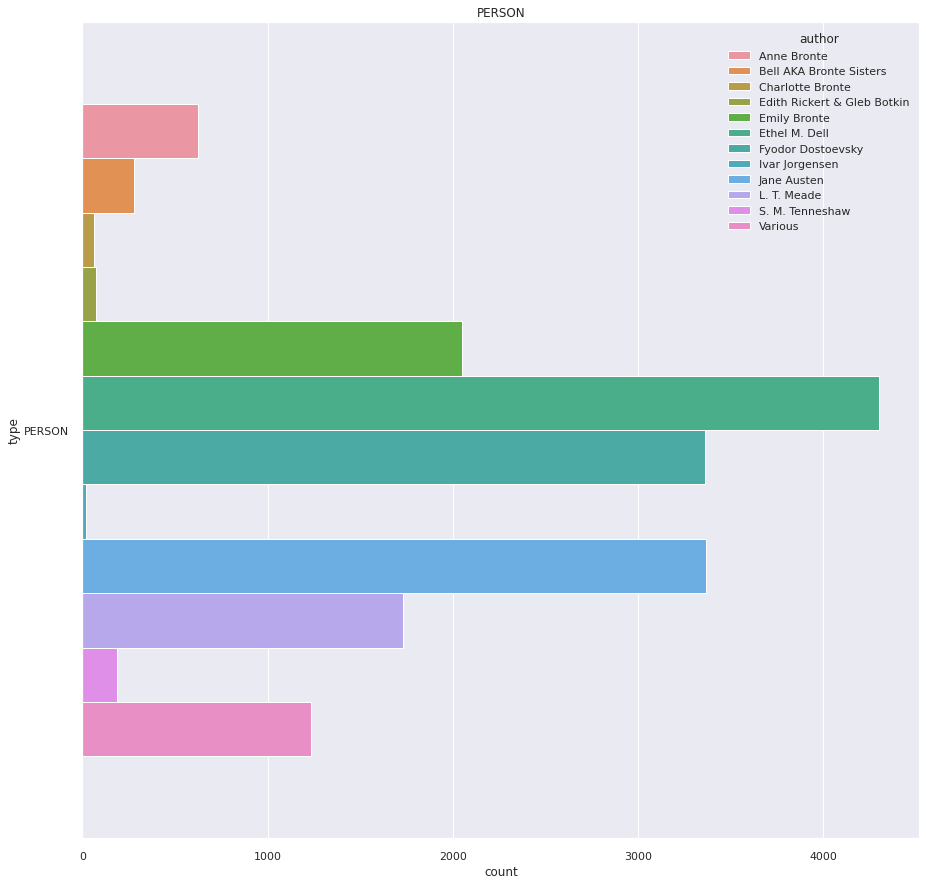

In [ ]:
# Graph of the number of Type "Person" in each text
sns.set_theme(style="darkgrid", palette="deep") 
person_plot = sns.countplot(y="type", hue="author", data=entities[entities.type == 'PERSON'])
person_plot.figure.set_size_inches(15,15) 
person_plot.set_title("PERSON") 

> Words of PERSON type appear many in the the novels of Ethel M. Dell, Emily Bronte and Fyodor Dostoevsky.

Text(0.5, 1.0, 'MIDDLE RANGE')

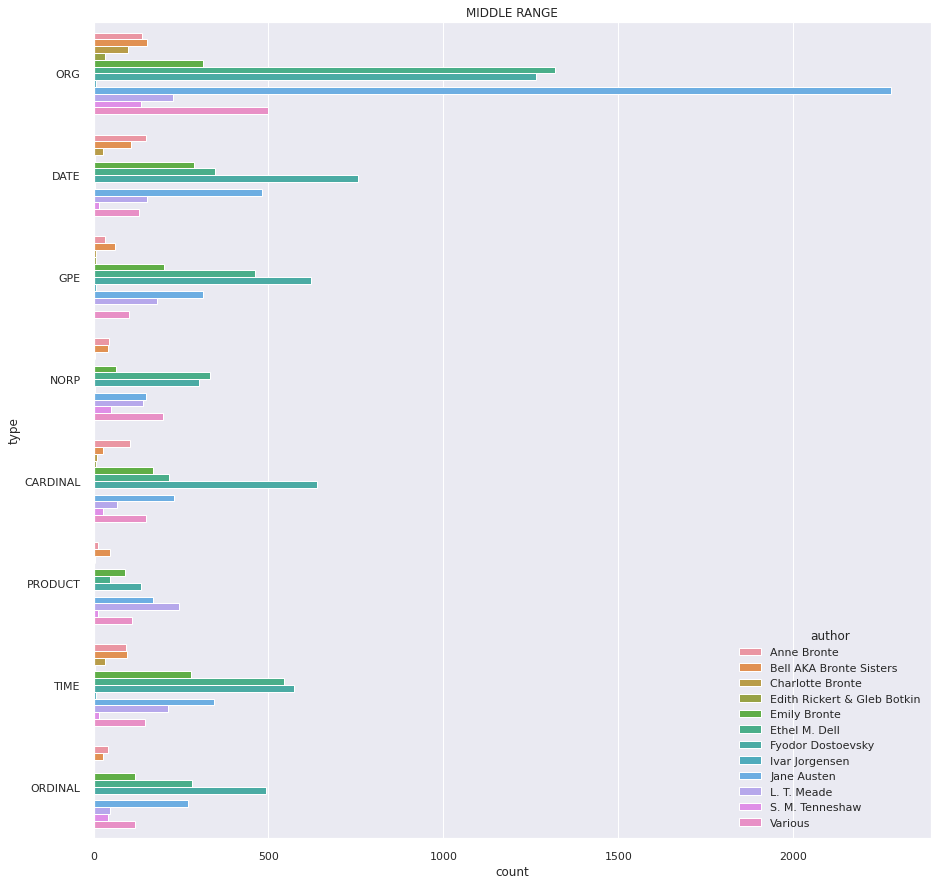

In [ ]:
mid_range = entities.type.value_counts()[(entities.type.value_counts() >= 700) & (entities.type.value_counts() <= 9000)].keys()
middle_plot = sns.countplot(y="type", hue="author", data=entities[entities.type.isin(mid_range)])
middle_plot.figure.set_size_inches(15,15) 
middle_plot.set_title("MIDDLE RANGE") 

> Jane Austen's novels appear many words related to the ORG type.

> The novels of Fyodor Dostoevsky, Ivar Jorgensen appear many words of DATE, TIME, NORP, CARDINAL type.

Text(0.5, 1.0, 'LOW RANGE')

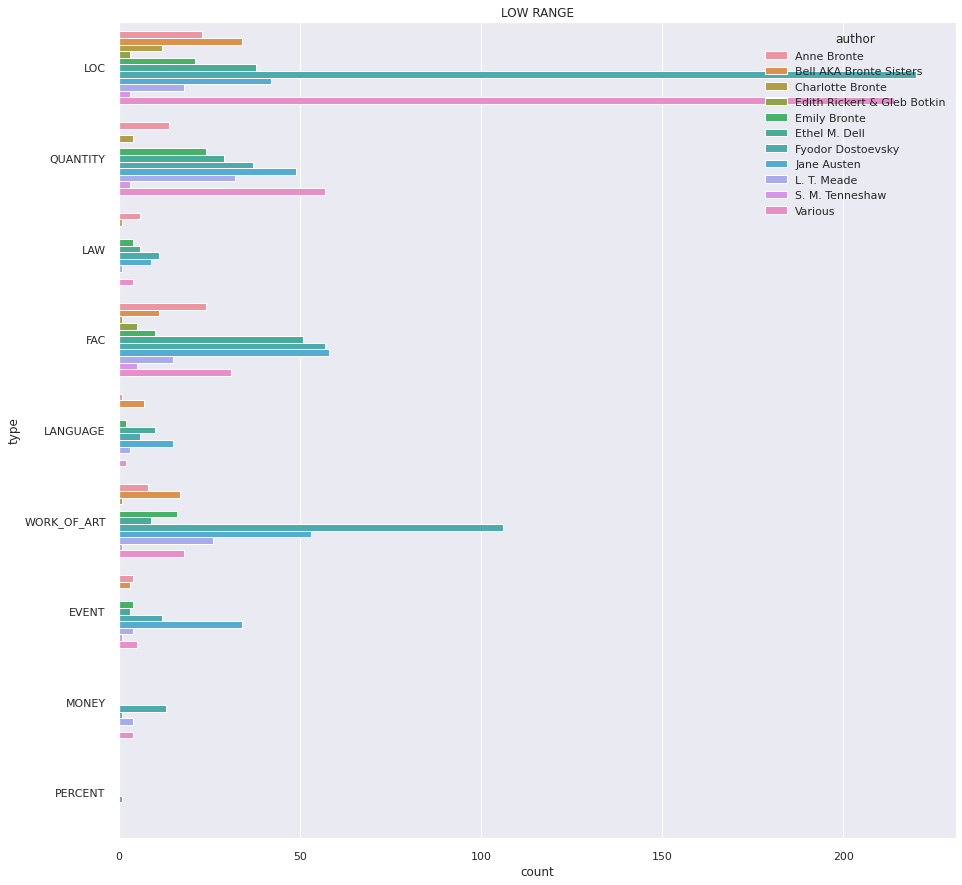

In [ ]:
low_range = entities.type.value_counts()[(entities.type.value_counts() < 700)].keys()
low_plot = sns.countplot(y="type", hue="author", data=entities[entities.type.isin(low_range)])
low_plot.figure.set_size_inches(15,15) 
low_plot.set_title("LOW RANGE") 

> Novels by Fyodor Dostoevsky and Various appear many words related to the LOC type.

In [ ]:
# The persons
persons = entities[entities.type.isin(['PERSON', 'ORG'])]
persons = persons.groupby(by='name', as_index=False)['author']
people = persons.nunique().sort_values(by='author', ascending=False)
people.describe()

,author
count,4288.000000
mean,1.093050
std,0.447337
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,9.000000


In [ ]:
people[people.author >= 5]

,name,author
603,chapter,9
2742,moon,8
1852,hush,6
3865,thou,6
915,didn,6
1810,house,6
2644,messenger,6
1216,farewell,5
3692,stay,5
2567,mary,5


#### 1.3.3  Post-analytical processing

In [ ]:
# Dataframe of sentences and authors
for fileid in new_novel_corpus.fileids():
  novel = pd.DataFrame(new_novel_corpus.raw(fileids=fileid).split('\n'), columns=['sentence'])
  novel['author'] = fileid.split('/')[0]
  try:
    novels = pd.concat([novels, novel])
  except NameError: 
    novels = novel

In [ ]:
# Remove empty strings
novels = novels.replace(r'^\s*$', np.NaN, regex=True)
novels.dropna(inplace=True)
novels.reindex()

# Remove contents and chapter titles
i = 0
for sent in novels.sentence:
  if any(c.islower() for c in sent) == False:
    novels.iloc[i] = np.NaN
  if 'project gutenberg' in sent.lower():
    novels.iloc[i] = np.NaN    
  if 'contents' == sent.lower().strip():
    novels.iloc[i] == np.NaN
  i += 1

novels.dropna(inplace=True)
novels.reindex()

# Drop the content headers
content_index = novels[novels.sentence == 'Contents '].index.values
novels.drop(content_index, inplace=True)

In [ ]:
# Tokenize the data
tokenizer = RegexpTokenizer(r'\w+')
novels['tokenized'] = [tokenizer.tokenize(sent.lower()) for sent in novels.sentence 
                   if tokenizer.tokenize(sent.lower()) not in stopwords.words('english')]

In [ ]:
# Lemmatize the tokens for RNN
lemmatizer_RNN = WordNetLemmatizer()
lemmatized_RNN = []
for token in novels.tokenized:
  lemmatized_RNN.append(' '.join([lemmatizer_RNN.lemmatize(word) for word in token]))
novels['lemmatized_RNN'] = lemmatized_RNN

In [ ]:
# Lemmatize the tokens
lemmatizer = WordNetLemmatizer()
lemmatized = []
for token in novels.tokenized:
  lemmatized.append([lemmatizer.lemmatize(word) for word in token])
novels['lemmatized'] = lemmatized

# Declare the variables
X = novels['lemmatized']
y = novels['author']

In [ ]:
novels.head()

,sentence,author,tokenized,lemmatized_RNN,lemmatized
0,Agnes Grey NOVEL,Anne Bronte,"[agnes, grey, novel]",agnes grey novel,"[agnes, grey, novel]"
4,Illustration Birthplace Charlotte Emily Anne B...,Anne Bronte,"[illustration, birthplace, charlotte, emily, a...",illustration birthplace charlotte emily anne b...,"[illustration, birthplace, charlotte, emily, a..."
8,true histories contain instruction though some...,Anne Bronte,"[true, histories, contain, instruction, though...",true history contain instruction though some t...,"[true, history, contain, instruction, though, ..."
9,father clergyman north England deservedly resp...,Anne Bronte,"[father, clergyman, north, england, deservedly...",father clergyman north england deservedly resp...,"[father, clergyman, north, england, deservedly..."
10,Finding arguments avail father length told lov...,Anne Bronte,"[finding, arguments, avail, father, length, to...",finding argument avail father length told love...,"[finding, argument, avail, father, length, tol..."


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
X_train = X_train.astype(str)
X_test = X_test.astype(str)



---


## **2. Bag of Words** 

### **2.1 Naive Bayes** 

In [ ]:
pipeline = Pipeline([('vectorizer', CountVectorizer(analyzer='word')), ('nb', ComplementNB())])
parameters = {'vectorizer__max_df': (0.5, 0.75, 1.0), 'vectorizer__max_features': (None, 5000, 10000, 50000)}
BOW_search_NB = GridSearchCV(pipeline, parameters, cv=5, verbose=3)
BOW_search_NB.fit(X_train, y_train)   
BOW_Model_NB = BOW_search_NB.best_estimator_
BOW_Model_NB.fit(X_train, y_train)
y_pred = BOW_Model_NB.predict(X_test)
print(classification_report(y_test, y_pred))

                             precision    recall  f1-score   support

                Anne Bronte       0.82      0.42      0.55       197
    Bell AKA Bronte Sisters       0.83      0.85      0.84       168
           Charlotte Bronte       0.86      0.72      0.78        25
Edith Rickert & Gleb Botkin       0.92      0.69      0.79        35
               Emily Bronte       0.81      0.82      0.82       371
              Ethel M. Dell       0.87      0.91      0.89      1724
          Fyodor Dostoevsky       0.80      0.87      0.83      1081
             Ivar Jorgensen       1.00      0.33      0.50        15
                Jane Austen       0.71      0.94      0.81       524
                L. T. Meade       0.91      0.72      0.81       533
            S. M. Tenneshaw       0.97      0.57      0.72       181
                    Various       0.91      0.81      0.86       443

                   accuracy                           0.84      5297
                  macro avg     

In [ ]:
BOW_Model_NB

Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=0.5,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('nb',
                 ComplementNB(alpha=1.0, class_prior=None, fit_prior=True,
                              norm=False))],
         verbose=False)

### **2.2 Logistic Regression** 

In [ ]:
pipeline = Pipeline([('vectorizer', CountVectorizer(analyzer='word')), ('lr', LogisticRegression())])
parameters =  { 'vectorizer__max_df': (0.5, 0.75, 1.0),'vectorizer__max_features': (None, 5000, 10000, 50000), "lr__max_iter": [n for n in range(450, 600, 50)]}
BOW_search_LR = GridSearchCV(pipeline, parameters, cv=5, verbose=3)
BOW_search_LR.fit(X_train, y_train)  
BOW_Model_LR = BOW_search_LR.best_estimator_
BOW_Model_LR.fit(X_train, y_train)
y_pred = BOW_Model_LR.predict(X_test)
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] lr__max_iter=450, vectorizer__max_df=0.5, vectorizer__max_features=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  lr__max_iter=450, vectorizer__max_df=0.5, vectorizer__max_features=None, score=0.795, total=  40.8s
[CV] lr__max_iter=450, vectorizer__max_df=0.5, vectorizer__max_features=None 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   40.8s remaining:    0.0s


[CV]  lr__max_iter=450, vectorizer__max_df=0.5, vectorizer__max_features=None, score=0.804, total=  41.5s
[CV] lr__max_iter=450, vectorizer__max_df=0.5, vectorizer__max_features=None 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.4min remaining:    0.0s


[CV]  lr__max_iter=450, vectorizer__max_df=0.5, vectorizer__max_features=None, score=0.803, total=  40.7s
[CV] lr__max_iter=450, vectorizer__max_df=0.5, vectorizer__max_features=None 
[CV]  lr__max_iter=450, vectorizer__max_df=0.5, vectorizer__max_features=None, score=0.798, total=  40.0s
[CV] lr__max_iter=450, vectorizer__max_df=0.5, vectorizer__max_features=None 
[CV]  lr__max_iter=450, vectorizer__max_df=0.5, vectorizer__max_features=None, score=0.810, total=  41.7s
[CV] lr__max_iter=450, vectorizer__max_df=0.5, vectorizer__max_features=5000 
[CV]  lr__max_iter=450, vectorizer__max_df=0.5, vectorizer__max_features=5000, score=0.791, total=  30.4s
[CV] lr__max_iter=450, vectorizer__max_df=0.5, vectorizer__max_features=5000 
[CV]  lr__max_iter=450, vectorizer__max_df=0.5, vectorizer__max_features=5000, score=0.801, total=  30.7s
[CV] lr__max_iter=450, vectorizer__max_df=0.5, vectorizer__max_features=5000 
[CV]  lr__max_iter=450, vectorizer__max_df=0.5, vectorizer__max_features=5000, s

[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed: 109.1min finished


                             precision    recall  f1-score   support

                Anne Bronte       0.76      0.52      0.62       174
    Bell AKA Bronte Sisters       0.85      0.74      0.79       166
           Charlotte Bronte       0.89      0.44      0.59        18
Edith Rickert & Gleb Botkin       0.88      0.61      0.72        38
               Emily Bronte       0.88      0.73      0.80       427
              Ethel M. Dell       0.82      0.90      0.86      1749
          Fyodor Dostoevsky       0.73      0.87      0.79      1088
             Ivar Jorgensen       1.00      0.20      0.33        15
                Jane Austen       0.89      0.80      0.84       525
                L. T. Meade       0.80      0.76      0.78       489
            S. M. Tenneshaw       0.83      0.55      0.66       155
                    Various       0.85      0.75      0.80       453

                   accuracy                           0.81      5297
                  macro avg     

In [ ]:
BOW_Model_LR

Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=0.5,
                                 max_features=10000, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('lr',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=450,
                                    multi_class='auto', n_jobs=None,
                    

### **2.3 Decision Tree** 

In [ ]:
pipeline = Pipeline([('vectorizer', CountVectorizer(analyzer='word')), ('dt', DecisionTreeClassifier())])
parameters =  {'vectorizer__max_df': (0.5, 0.75, 1.0),'vectorizer__max_features': (None, 5000, 10000, 50000),'dt__max_depth': [n for n in range(25, 500, 50)]}
BOW_search_DT = GridSearchCV(pipeline, parameters, cv=5, verbose=3)
BOW_search_DT.fit(X_train, y_train)   
BOW_Model_DT = BOW_search_DT.best_estimator_
BOW_Model_DT.fit(X_train, y_train)
y_pred = BOW_Model_DT.predict(X_test)
print(classification_report(y_test, y_pred))

[CV]  dt__max_depth=375, vectorizer__max_df=1.0, vectorizer__max_features=50000, score=0.641, total=   6.4s
[CV] dt__max_depth=375, vectorizer__max_df=1.0, vectorizer__max_features=50000 
[CV]  dt__max_depth=375, vectorizer__max_df=1.0, vectorizer__max_features=50000, score=0.630, total=   6.5s
[CV] dt__max_depth=375, vectorizer__max_df=1.0, vectorizer__max_features=50000 
[CV]  dt__max_depth=375, vectorizer__max_df=1.0, vectorizer__max_features=50000, score=0.643, total=   6.2s
[CV] dt__max_depth=375, vectorizer__max_df=1.0, vectorizer__max_features=50000 
[CV]  dt__max_depth=375, vectorizer__max_df=1.0, vectorizer__max_features=50000, score=0.643, total=   6.5s
[CV] dt__max_depth=375, vectorizer__max_df=1.0, vectorizer__max_features=50000 
[CV]  dt__max_depth=375, vectorizer__max_df=1.0, vectorizer__max_features=50000, score=0.648, total=   6.4s
[CV] dt__max_depth=425, vectorizer__max_df=0.5, vectorizer__max_features=None 
[CV]  dt__max_depth=425, vectorizer__max_df=0.5, vectorizer__

[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed: 47.5min finished


                             precision    recall  f1-score   support

                Anne Bronte       0.34      0.24      0.28       174
    Bell AKA Bronte Sisters       0.43      0.37      0.40       166
           Charlotte Bronte       0.58      0.39      0.47        18
Edith Rickert & Gleb Botkin       0.64      0.47      0.55        38
               Emily Bronte       0.73      0.59      0.65       427
              Ethel M. Dell       0.74      0.77      0.75      1749
          Fyodor Dostoevsky       0.54      0.72      0.62      1088
             Ivar Jorgensen       0.33      0.13      0.19        15
                Jane Austen       0.72      0.63      0.68       525
                L. T. Meade       0.68      0.62      0.65       489
            S. M. Tenneshaw       0.52      0.37      0.43       155
                    Various       0.71      0.58      0.64       453

                   accuracy                           0.65      5297
                  macro avg     

In [ ]:
BOW_Model_DT

Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('dt',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=275,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
            

### **2.4 Random Forest** 

In [ ]:
pipeline = Pipeline([('vectorizer', CountVectorizer(analyzer='word')), ('rf', RandomForestClassifier())])
parameters =  {'vectorizer__max_df': (0.5, 0.75, 1.0),'rf__max_depth':  [n for n in range(100, 20000, 9900)],'rf__n_estimators':  [n for n in range(100, 500, 100)],}
BOW_search_RF = GridSearchCV(pipeline, parameters, cv=5, verbose=3)
BOW_search_RF.fit(X_train, y_train)   
BOW_Model_RF = BOW_search_RF.best_estimator_
BOW_Model_RF.fit(X_train, y_train)
y_pred = BOW_Model_RF.predict(X_test)
print(classification_report(y_test, y_pred))

                             precision    recall  f1-score   support

                Anne Bronte       0.59      0.16      0.25       197
    Bell AKA Bronte Sisters       0.89      0.40      0.56       168
           Charlotte Bronte       0.92      0.48      0.63        25
Edith Rickert & Gleb Botkin       0.81      0.49      0.61        35
               Emily Bronte       0.91      0.65      0.76       371
              Ethel M. Dell       0.72      0.92      0.81      1724
          Fyodor Dostoevsky       0.66      0.83      0.73      1081
             Ivar Jorgensen       0.75      0.20      0.32        15
                Jane Austen       0.83      0.74      0.78       524
                L. T. Meade       0.80      0.63      0.71       533
            S. M. Tenneshaw       0.80      0.40      0.53       181
                    Various       0.86      0.61      0.71       443

                   accuracy                           0.74      5297
                  macro avg     

In [ ]:
BOW_Model_RF

Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabula...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=19900, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                               

### **2.5 K - Nearest Neighbors** 

In [ ]:
pipeline = Pipeline([('vectorizer', CountVectorizer(analyzer='word')), ('knn', KNeighborsClassifier())])
parameters =  {'vectorizer__max_df': (0.5, 0.75, 1.0),'vectorizer__max_features': (None, 5000, 10000, 50000),'knn__n_neighbors': [39, 17],'knn__leaf_size': [30, 12],}
BOW_search_KNN = GridSearchCV(pipeline, parameters, cv=5, verbose=3)
BOW_search_KNN.fit(X_train, y_train)    
BOW_Model_KNN = BOW_search_KNN.best_estimator_
BOW_Model_KNN.fit(X_train, y_train)
y_pred = BOW_Model_KNN.predict(X_test)
print(classification_report(y_test, y_pred))

[CV]  knn__leaf_size=12, knn__n_neighbors=39, vectorizer__max_df=0.5, vectorizer__max_features=5000, score=0.340, total=   2.2s
[CV] knn__leaf_size=12, knn__n_neighbors=39, vectorizer__max_df=0.5, vectorizer__max_features=10000 
[CV]  knn__leaf_size=12, knn__n_neighbors=39, vectorizer__max_df=0.5, vectorizer__max_features=10000, score=0.356, total=   2.7s
[CV] knn__leaf_size=12, knn__n_neighbors=39, vectorizer__max_df=0.5, vectorizer__max_features=10000 
[CV]  knn__leaf_size=12, knn__n_neighbors=39, vectorizer__max_df=0.5, vectorizer__max_features=10000, score=0.356, total=   2.7s
[CV] knn__leaf_size=12, knn__n_neighbors=39, vectorizer__max_df=0.5, vectorizer__max_features=10000 
[CV]  knn__leaf_size=12, knn__n_neighbors=39, vectorizer__max_df=0.5, vectorizer__max_features=10000, score=0.354, total=   2.6s
[CV] knn__leaf_size=12, knn__n_neighbors=39, vectorizer__max_df=0.5, vectorizer__max_features=10000 
[CV]  knn__leaf_size=12, knn__n_neighbors=39, vectorizer__max_df=0.5, vectorizer_

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed: 10.2min finished


                             precision    recall  f1-score   support

                Anne Bronte       0.15      0.02      0.03       197
    Bell AKA Bronte Sisters       1.00      0.01      0.01       168
           Charlotte Bronte       1.00      0.08      0.15        25
Edith Rickert & Gleb Botkin       0.64      0.20      0.30        35
               Emily Bronte       0.44      0.04      0.08       371
              Ethel M. Dell       0.51      0.56      0.53      1724
          Fyodor Dostoevsky       0.28      0.75      0.41      1081
             Ivar Jorgensen       0.00      0.00      0.00        15
                Jane Austen       0.78      0.13      0.22       524
                L. T. Meade       0.35      0.17      0.23       533
            S. M. Tenneshaw       0.67      0.07      0.12       181
                    Various       0.65      0.14      0.23       443

                   accuracy                           0.38      5297
                  macro avg     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
BOW_Model_KNN

Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=0.5,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('knn',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=17, p=2,
                                      weights='uniform'))],
         verbose=False)

### **2.6 Support Vector Machine** 

In [ ]:
pipeline = Pipeline([('vectorizer', CountVectorizer(analyzer='word')), ('sv', SVC())])
parameters =  {'vectorizer__max_df': (0.5, 0.75, 1.0),'sv__kernel': ['linear', 'rbf'],}
BOW_search_SVM = GridSearchCV(pipeline, parameters, cv=5, verbose=3)
BOW_search_SVM.fit(X_train, y_train) 
BOW_Model_SVM = BOW_search_SVM.best_estimator_
BOW_Model_SVM.fit(X_train, y_train)
y_pred = BOW_Model_SVM.predict(X_test) 
print(classification_report(y_test, y_pred))

[CV]  sv__kernel=rbf, vectorizer__max_df=1.0, score=0.711, total= 1.9min
[CV] sv__kernel=rbf, vectorizer__max_df=1.0 ..........................
[CV]  sv__kernel=rbf, vectorizer__max_df=1.0, score=0.704, total= 1.9min


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 41.0min finished


                             precision    recall  f1-score   support

                Anne Bronte       0.52      0.48      0.50       197
    Bell AKA Bronte Sisters       0.63      0.76      0.69       168
           Charlotte Bronte       0.84      0.64      0.73        25
Edith Rickert & Gleb Botkin       0.80      0.69      0.74        35
               Emily Bronte       0.80      0.71      0.75       371
              Ethel M. Dell       0.81      0.87      0.84      1724
          Fyodor Dostoevsky       0.70      0.84      0.76      1081
             Ivar Jorgensen       0.55      0.40      0.46        15
                Jane Austen       0.83      0.77      0.80       524
                L. T. Meade       0.78      0.66      0.71       533
            S. M. Tenneshaw       0.78      0.55      0.65       181
                    Various       0.86      0.64      0.73       443

                   accuracy                           0.77      5297
                  macro avg     

In [ ]:
BOW_Model_SVM

Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=0.5,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('sv',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='linear', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
           

### **2.7 Gradient Boosting** 

In [ ]:
pipeline = Pipeline([('vectorizer', CountVectorizer(analyzer='word')), ('gb', GradientBoostingClassifier())])
parameters =  {'gb__max_depth': [n for n in range(300, 400, 100)],}
BOW_search_GB = GridSearchCV(pipeline, parameters, cv=5, verbose=3)
BOW_search_GB.fit(X_train, y_train)
BOW_Model_GB = BOW_search_GB.best_estimator_
BOW_Model_GB.fit(X_train, y_train)
y_pred = BOW_Model_GB.predict(X_test)
print(classification_report(y_test, y_pred))

[CV] ................... gb__max_depth=300, score=0.734, total=42.8min
[CV] gb__max_depth=300 ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 42.8min remaining:    0.0s


[CV] ................... gb__max_depth=300, score=0.735, total=41.6min
[CV] gb__max_depth=300 ...............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 84.4min remaining:    0.0s


[CV] ................... gb__max_depth=300, score=0.741, total=41.6min
[CV] gb__max_depth=300 ...............................................
[CV] ................... gb__max_depth=300, score=0.742, total=41.6min
[CV] gb__max_depth=300 ...............................................
[CV] ................... gb__max_depth=300, score=0.738, total=41.0min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 208.6min finished


                             precision    recall  f1-score   support

                Anne Bronte       0.58      0.48      0.52       197
    Bell AKA Bronte Sisters       0.82      0.50      0.62       168
           Charlotte Bronte       0.60      0.72      0.65        25
Edith Rickert & Gleb Botkin       0.73      0.63      0.68        35
               Emily Bronte       0.83      0.70      0.76       371
              Ethel M. Dell       0.77      0.85      0.81      1724
          Fyodor Dostoevsky       0.69      0.79      0.74      1081
             Ivar Jorgensen       0.39      0.60      0.47        15
                Jane Austen       0.87      0.75      0.81       524
                L. T. Meade       0.75      0.68      0.72       533
            S. M. Tenneshaw       0.74      0.59      0.65       181
                    Various       0.77      0.72      0.74       443

                   accuracy                           0.75      5297
                  macro avg     

In [ ]:
BOW_Model_GB

Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabula...
                                            learning_rate=0.1, loss='deviance',
                                            max_depth=300, max_features=None,
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
                                          

### **2.8 Conclusion** 

> Naive Bayes and Logistic Regression model gives best results.

> The remaining models except K-NN give quite good and equivalent results.

> The time to train Logistic Regression and Gradient Boosting model is very long.



---


## **3. Term Frequency-Inverse Document Frequency** 




### **3.1 Naive Bayes** 

In [ ]:
pipeline = Pipeline([('vectorizer', TfidfVectorizer(min_df=2, use_idf=True, norm=u'l2', smooth_idf=True)), ('nb', ComplementNB())])
parameters = {'vectorizer__max_df': (0.5, 0.75, 1.0),'vectorizer__max_features': (None, 5000, 10000, 50000)}
TF_IDF_search_NB = GridSearchCV(pipeline, parameters, cv=5, verbose=3)
TF_IDF_search_NB.fit(X_train, y_train)
TF_IDF_Model_NB = TF_IDF_search_NB.best_estimator_
TF_IDF_Model_NB.fit(X_train, y_train)
y_pred = TF_IDF_Model_NB.predict(X_test)   
print(classification_report(y_test, y_pred))

[CV]  vectorizer__max_df=1.0, vectorizer__max_features=None, score=0.824, total=   0.7s
[CV] vectorizer__max_df=1.0, vectorizer__max_features=None ...........
[CV]  vectorizer__max_df=1.0, vectorizer__max_features=None, score=0.820, total=   0.7s
[CV] vectorizer__max_df=1.0, vectorizer__max_features=None ...........
[CV]  vectorizer__max_df=1.0, vectorizer__max_features=None, score=0.837, total=   0.7s
[CV] vectorizer__max_df=1.0, vectorizer__max_features=None ...........
[CV]  vectorizer__max_df=1.0, vectorizer__max_features=None, score=0.822, total=   0.7s
[CV] vectorizer__max_df=1.0, vectorizer__max_features=5000 ...........
[CV]  vectorizer__max_df=1.0, vectorizer__max_features=5000, score=0.805, total=   0.7s
[CV] vectorizer__max_df=1.0, vectorizer__max_features=5000 ...........
[CV]  vectorizer__max_df=1.0, vectorizer__max_features=5000, score=0.807, total=   0.7s
[CV] vectorizer__max_df=1.0, vectorizer__max_features=5000 ...........
[CV]  vectorizer__max_df=1.0, vectorizer__max_

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   42.7s finished


                             precision    recall  f1-score   support

                Anne Bronte       0.86      0.40      0.55       197
    Bell AKA Bronte Sisters       0.79      0.90      0.84       168
           Charlotte Bronte       0.79      0.60      0.68        25
Edith Rickert & Gleb Botkin       0.79      0.74      0.76        35
               Emily Bronte       0.85      0.78      0.81       371
              Ethel M. Dell       0.85      0.93      0.89      1724
          Fyodor Dostoevsky       0.83      0.84      0.84      1081
             Ivar Jorgensen       1.00      0.47      0.64        15
                Jane Austen       0.75      0.92      0.83       524
                L. T. Meade       0.87      0.76      0.81       533
            S. M. Tenneshaw       0.93      0.62      0.75       181
                    Various       0.90      0.82      0.86       443

                   accuracy                           0.84      5297
                  macro avg     

In [ ]:
TF_IDF_Model_NB

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.5, max_features=None,
                                 min_df=2, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('nb',
                 ComplementNB(alpha=1.0, class_prior=None, fit_prior=True,
                              norm=False))],
         verbose=False)

### **3.2 Logistic Regression** 

In [ ]:
pipeline = Pipeline([('vectorizer', TfidfVectorizer(min_df=2, use_idf=True, norm=u'l2', smooth_idf=True)), ('lr', LogisticRegression())])
parameters =  {'vectorizer__max_df': (0.5, 0.75, 1.0),'vectorizer__max_features': (None, 5000, 10000, 50000),"lr__max_iter": [n for n in range(450, 600, 50)]}
TF_IDF_search_LR = GridSearchCV(pipeline, parameters, cv=5, verbose=3)
TF_IDF_search_LR.fit(X_train, y_train)   
TF_IDF_Model_LR = TF_IDF_search_LR.best_estimator_
TF_IDF_Model_LR.fit(X_train, y_train)
y_pred = TF_IDF_Model_LR.predict(X_test)   
print(classification_report(y_test, y_pred))

[CV]  lr__max_iter=550, vectorizer__max_df=1.0, vectorizer__max_features=10000, score=0.793, total=  13.3s
[CV] lr__max_iter=550, vectorizer__max_df=1.0, vectorizer__max_features=10000 
[CV]  lr__max_iter=550, vectorizer__max_df=1.0, vectorizer__max_features=10000, score=0.782, total=  14.2s
[CV] lr__max_iter=550, vectorizer__max_df=1.0, vectorizer__max_features=10000 
[CV]  lr__max_iter=550, vectorizer__max_df=1.0, vectorizer__max_features=10000, score=0.800, total=  31.8s
[CV] lr__max_iter=550, vectorizer__max_df=1.0, vectorizer__max_features=10000 
[CV]  lr__max_iter=550, vectorizer__max_df=1.0, vectorizer__max_features=10000, score=0.785, total=  15.1s
[CV] lr__max_iter=550, vectorizer__max_df=1.0, vectorizer__max_features=50000 
[CV]  lr__max_iter=550, vectorizer__max_df=1.0, vectorizer__max_features=50000, score=0.782, total=  15.8s
[CV] lr__max_iter=550, vectorizer__max_df=1.0, vectorizer__max_features=50000 
[CV]  lr__max_iter=550, vectorizer__max_df=1.0, vectorizer__max_featur

[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed: 44.4min finished


                             precision    recall  f1-score   support

                Anne Bronte       0.96      0.40      0.57       197
    Bell AKA Bronte Sisters       0.86      0.72      0.79       168
           Charlotte Bronte       1.00      0.20      0.33        25
Edith Rickert & Gleb Botkin       1.00      0.31      0.48        35
               Emily Bronte       0.92      0.72      0.81       371
              Ethel M. Dell       0.77      0.95      0.85      1724
          Fyodor Dostoevsky       0.75      0.87      0.81      1081
             Ivar Jorgensen       0.00      0.00      0.00        15
                Jane Austen       0.87      0.84      0.86       524
                L. T. Meade       0.88      0.71      0.79       533
            S. M. Tenneshaw       0.95      0.42      0.58       181
                    Various       0.88      0.73      0.80       443

                   accuracy                           0.81      5297
                  macro avg     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
TF_IDF_Model_LR

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.5, max_features=10000,
                                 min_df=2, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('lr',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_sc

### **3.3 Decision Tree** 

In [ ]:
pipeline = Pipeline([('vectorizer',TfidfVectorizer(min_df=2, use_idf=True, norm=u'l2', smooth_idf=True)), ('dt', DecisionTreeClassifier())])
parameters =  {'vectorizer__max_df': (0.5, 0.75, 1.0),'vectorizer__max_features': (None, 5000, 10000, 50000),'dt__max_depth': [n for n in range(25, 500, 50)]}
TF_IDF_search_DT = GridSearchCV(pipeline, parameters, cv=5, verbose=3)
TF_IDF_search_DT.fit(X_train, y_train)
TF_IDF_Model_DT = TF_IDF_search_DT.best_estimator_
TF_IDF_Model_DT.fit(X_train, y_train)
y_pred = TF_IDF_Model_DT.predict(X_test)   
print(classification_report(y_test, y_pred))

[CV]  dt__max_depth=425, vectorizer__max_df=1.0, vectorizer__max_features=None, score=0.626, total=   7.2s
[CV] dt__max_depth=425, vectorizer__max_df=1.0, vectorizer__max_features=None 
[CV]  dt__max_depth=425, vectorizer__max_df=1.0, vectorizer__max_features=None, score=0.631, total=   7.1s
[CV] dt__max_depth=425, vectorizer__max_df=1.0, vectorizer__max_features=5000 
[CV]  dt__max_depth=425, vectorizer__max_df=1.0, vectorizer__max_features=5000, score=0.638, total=   6.1s
[CV] dt__max_depth=425, vectorizer__max_df=1.0, vectorizer__max_features=5000 
[CV]  dt__max_depth=425, vectorizer__max_df=1.0, vectorizer__max_features=5000, score=0.644, total=   6.1s
[CV] dt__max_depth=425, vectorizer__max_df=1.0, vectorizer__max_features=5000 
[CV]  dt__max_depth=425, vectorizer__max_df=1.0, vectorizer__max_features=5000, score=0.634, total=   6.1s
[CV] dt__max_depth=425, vectorizer__max_df=1.0, vectorizer__max_features=5000 
[CV]  dt__max_depth=425, vectorizer__max_df=1.0, vectorizer__max_featu

[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed: 57.2min finished


                             precision    recall  f1-score   support

                Anne Bronte       0.42      0.27      0.33       197
    Bell AKA Bronte Sisters       0.53      0.48      0.50       168
           Charlotte Bronte       0.78      0.56      0.65        25
Edith Rickert & Gleb Botkin       0.64      0.46      0.53        35
               Emily Bronte       0.67      0.61      0.64       371
              Ethel M. Dell       0.73      0.78      0.75      1724
          Fyodor Dostoevsky       0.57      0.73      0.64      1081
             Ivar Jorgensen       0.18      0.13      0.15        15
                Jane Austen       0.74      0.67      0.70       524
                L. T. Meade       0.71      0.57      0.63       533
            S. M. Tenneshaw       0.54      0.33      0.41       181
                    Various       0.66      0.57      0.61       443

                   accuracy                           0.66      5297
                  macro avg     

In [ ]:
TF_IDF_Model_DT

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=50000,
                                 min_df=2, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pat...
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('dt',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=375,
                 

### **3.4 Random Forest** 

In [ ]:
pipeline = Pipeline([('vectorizer', TfidfVectorizer(min_df=2, use_idf=True, norm=u'l2', smooth_idf=True)), ('rf', RandomForestClassifier())])
parameters =  {'vectorizer__max_df': (0.5, 0.75, 1.0),'rf__max_depth':  [n for n in range(100, 20000, 9900)],'rf__n_estimators':  [n for n in range(100, 500, 100)],}
TF_IDF_search_RF = GridSearchCV(pipeline, parameters, cv=5, verbose=3)
TF_IDF_search_RF.fit(X_train, y_train)
TF_IDF_Model_RF = TF_IDF_search_RF.best_estimator_
TF_IDF_Model_RF.fit(X_train, y_train)
y_pred = TF_IDF_Model_RF.predict(X_test)
print(classification_report(y_test, y_pred))

                             precision    recall  f1-score   support

                Anne Bronte       0.83      0.15      0.25       197
    Bell AKA Bronte Sisters       0.93      0.51      0.66       168
           Charlotte Bronte       0.92      0.48      0.63        25
Edith Rickert & Gleb Botkin       0.36      0.69      0.47        35
               Emily Bronte       0.90      0.65      0.75       371
              Ethel M. Dell       0.70      0.93      0.80      1724
          Fyodor Dostoevsky       0.67      0.81      0.73      1081
             Ivar Jorgensen       0.80      0.27      0.40        15
                Jane Austen       0.86      0.73      0.79       524
                L. T. Meade       0.86      0.62      0.72       533
            S. M. Tenneshaw       0.91      0.38      0.53       181
                    Various       0.91      0.64      0.75       443

                   accuracy                           0.74      5297
                  macro avg     

In [ ]:
TF_IDF_Model_RF

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.75, max_features=None,
                                 min_df=2, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pat...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=19900, max_features='auto',
                                        max_leaf_nodes=None, max_samples=Non

### **3.5 K - Nearest Neighbors** 

In [ ]:
pipeline = Pipeline([('vectorizer', TfidfVectorizer(min_df=2, use_idf=True, norm=u'l2', smooth_idf=True)), ('knn', KNeighborsClassifier())])
parameters =  {'vectorizer__max_df': (0.5, 0.75, 1.0),'vectorizer__max_features': (None, 5000, 10000, 50000),'knn__n_neighbors': [39, 17], 'knn__leaf_size': [30, 12], }
TF_IDF_search__KNN = GridSearchCV(pipeline, parameters, cv=5, verbose=3)
TF_IDF_search__KNN.fit(X_train, y_train)
TF_IDF_Model_KNN = TF_IDF_search__KNN.best_estimator_
TF_IDF_Model_KNN.fit(X_train, y_train)
y_pred = TF_IDF_Model_KNN.predict(X_test)   
print(classification_report(y_test, y_pred))

[CV]  knn__leaf_size=12, knn__n_neighbors=17, vectorizer__max_df=0.5, vectorizer__max_features=5000, score=0.204, total=   3.1s
[CV] knn__leaf_size=12, knn__n_neighbors=17, vectorizer__max_df=0.5, vectorizer__max_features=5000 
[CV]  knn__leaf_size=12, knn__n_neighbors=17, vectorizer__max_df=0.5, vectorizer__max_features=5000, score=0.163, total=   3.2s
[CV] knn__leaf_size=12, knn__n_neighbors=17, vectorizer__max_df=0.5, vectorizer__max_features=10000 
[CV]  knn__leaf_size=12, knn__n_neighbors=17, vectorizer__max_df=0.5, vectorizer__max_features=10000, score=0.551, total=   3.1s
[CV] knn__leaf_size=12, knn__n_neighbors=17, vectorizer__max_df=0.5, vectorizer__max_features=10000 
[CV]  knn__leaf_size=12, knn__n_neighbors=17, vectorizer__max_df=0.5, vectorizer__max_features=10000, score=0.236, total=   3.1s
[CV] knn__leaf_size=12, knn__n_neighbors=17, vectorizer__max_df=0.5, vectorizer__max_features=10000 
[CV]  knn__leaf_size=12, knn__n_neighbors=17, vectorizer__max_df=0.5, vectorizer__m

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed: 12.8min finished


                             precision    recall  f1-score   support

                Anne Bronte       0.90      0.18      0.30       197
    Bell AKA Bronte Sisters       0.85      0.21      0.33       168
           Charlotte Bronte       1.00      0.28      0.44        25
Edith Rickert & Gleb Botkin       0.73      0.54      0.62        35
               Emily Bronte       0.86      0.24      0.37       371
              Ethel M. Dell       0.72      0.86      0.78      1724
          Fyodor Dostoevsky       0.50      0.87      0.64      1081
             Ivar Jorgensen       1.00      0.20      0.33        15
                Jane Austen       0.92      0.61      0.74       524
                L. T. Meade       0.75      0.63      0.69       533
            S. M. Tenneshaw       0.91      0.35      0.50       181
                    Various       0.97      0.58      0.72       443

                   accuracy                           0.68      5297
                  macro avg     

In [ ]:
TF_IDF_Model_KNN

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.5, max_features=None,
                                 min_df=2, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('knn',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=

### **3.6 Support Vector Machine** 

In [ ]:
pipeline = Pipeline([('vectorizer',TfidfVectorizer(min_df=2, use_idf=True, norm=u'l2', smooth_idf=True)), ('sv', SVC())])
parameters =  {'vectorizer__max_df': (0.5, 0.75, 1.0),'sv__kernel': ['linear', 'rbf'],}
TF_IDF_search_SVM = GridSearchCV(pipeline, parameters, cv=5, verbose=3)
TF_IDF_search_SVM.fit(X_train, y_train)
TF_IDF_Model_SVM = TF_IDF_search_SVM.best_estimator_
TF_IDF_Model_SVM.fit(X_train, y_train)
y_pred = TF_IDF_Model_SVM.predict(X_test)
print(classification_report(y_test, y_pred))

                             precision    recall  f1-score   support

                Anne Bronte       0.88      0.50      0.64       197
    Bell AKA Bronte Sisters       0.87      0.77      0.82       168
           Charlotte Bronte       0.94      0.60      0.73        25
Edith Rickert & Gleb Botkin       1.00      0.60      0.75        35
               Emily Bronte       0.90      0.74      0.81       371
              Ethel M. Dell       0.79      0.94      0.86      1724
          Fyodor Dostoevsky       0.74      0.87      0.80      1081
             Ivar Jorgensen       1.00      0.40      0.57        15
                Jane Austen       0.90      0.84      0.87       524
                L. T. Meade       0.89      0.70      0.78       533
            S. M. Tenneshaw       0.96      0.52      0.68       181
                    Various       0.91      0.74      0.82       443

                   accuracy                           0.82      5297
                  macro avg     

In [ ]:
TF_IDF_Model_SVM

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.5, max_features=None,
                                 min_df=2, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('sv',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr',

### **3.7 Gradient Boosting** 

In [ ]:
TF_IDF_Model_GB = Pipeline([('vectorizer', TfidfVectorizer(min_df=2, use_idf=True, norm=u'l2', smooth_idf=True)), ('gb', GradientBoostingClassifier())])
# parameters =  {'gb__max_depth': [400]}
# TF_IDF_search_GB = GridSearchCV(pipeline, parameters, cv=5, verbose=3)
# TF_IDF_search_GB.fit(X_train, y_train) 
# TF_IDF_Model_GB = TF_IDF_search_GB.best_estimator_
TF_IDF_Model_GB.fit(X_train, y_train)
y_pred = TF_IDF_Model_GB.predict(X_test) 
print(classification_report(y_test, y_pred))

                             precision    recall  f1-score   support

                Anne Bronte       0.82      0.46      0.59       197
    Bell AKA Bronte Sisters       0.86      0.55      0.67       168
           Charlotte Bronte       0.79      0.76      0.78        25
Edith Rickert & Gleb Botkin       0.70      0.54      0.61        35
               Emily Bronte       0.97      0.65      0.78       371
              Ethel M. Dell       0.60      0.95      0.73      1724
          Fyodor Dostoevsky       0.78      0.67      0.72      1081
             Ivar Jorgensen       0.35      0.40      0.38        15
                Jane Austen       0.94      0.70      0.80       524
                L. T. Meade       0.96      0.59      0.73       533
            S. M. Tenneshaw       0.90      0.48      0.63       181
                    Various       0.98      0.59      0.74       443

                   accuracy                           0.73      5297
                  macro avg     

In [ ]:
TF_IDF_Model_GB

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=2, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...
                                            learning_rate=0.1, loss='deviance',
                                            max_depth=3, max_features=None,
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
          

### **3.8 Conclusion** 

> Naive Bayes and Support Vector Machine models give the best results. 

> The remaining models excepts give not very good results and are equivalent.

> The results are equivalent to the Bag of Words method.





---


## **4. Word to vector** 

### **4.1 W2V using Lemmatization** 

In [ ]:
vector_size = max(len(x) for x in novels['lemmatized'] ) 
model_w2c =  Word2Vec(novels['lemmatized'], min_count = 1, seed = 1, size=vector_size)
word2vec_arr = np.zeros((novels.shape[0], model_w2c.vector_size))
for i, sentence in enumerate(novels['lemmatized']):
    word2vec_arr[i,:] = np.mean([model_w2c[word] for word in sentence], axis=0)
X_w2c = word2vec_arr

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


In [ ]:
X_train_w2c, X_test_w2c, y_train_w2c, y_test_w2c = train_test_split(X_w2c, y, test_size=0.2, random_state=10)

#### **4.1.1 Naive Bayes** 

In [ ]:
pipeline = Pipeline([('s', MinMaxScaler()), ('nb', ComplementNB())])
parameters = {'s__feature_range' : [(0, abs(X_w2c).max()), (0, 1), (0, 2*abs(X_w2c).max()), (0, 5*abs(X_w2c).max())]}
W2V_search_NB = GridSearchCV(pipeline, parameters, cv=5, verbose=3)
W2V_search_NB.fit(X_train_w2c, y_train_w2c)
W2V_Model_NB = W2V_search_NB.best_estimator_
W2V_Model_NB.fit(X_train_w2c, y_train_w2c)
y_pred = W2V_Model_NB.predict(X_test_w2c)
print(classification_report(y_test_w2c, y_pred))

[CV]  s__feature_range=(0, 1.3865536451339722), score=0.291, total=   0.6s
[CV] s__feature_range=(0, 1.3865536451339722) ........................
[CV]  s__feature_range=(0, 1.3865536451339722), score=0.284, total=   0.6s
[CV] s__feature_range=(0, 3.4663841128349304) ........................
[CV]  s__feature_range=(0, 3.4663841128349304), score=0.288, total=   0.6s
[CV] s__feature_range=(0, 3.4663841128349304) ........................
[CV]  s__feature_range=(0, 3.4663841128349304), score=0.292, total=   0.6s
[CV] s__feature_range=(0, 3.4663841128349304) ........................
[CV]  s__feature_range=(0, 3.4663841128349304), score=0.293, total=   0.6s
[CV] s__feature_range=(0, 3.4663841128349304) ........................
[CV]  s__feature_range=(0, 3.4663841128349304), score=0.291, total=   0.6s
[CV] s__feature_range=(0, 3.4663841128349304) ........................
[CV]  s__feature_range=(0, 3.4663841128349304), score=0.284, total=   0.6s


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   12.0s finished


                             precision    recall  f1-score   support

                Anne Bronte       0.00      0.00      0.00       197
    Bell AKA Bronte Sisters       0.00      0.00      0.00       168
           Charlotte Bronte       0.00      0.00      0.00        25
Edith Rickert & Gleb Botkin       0.00      0.00      0.00        35
               Emily Bronte       0.00      0.00      0.00       371
              Ethel M. Dell       0.46      0.48      0.47      1724
          Fyodor Dostoevsky       0.27      0.05      0.08      1081
             Ivar Jorgensen       0.00      0.00      0.00        15
                Jane Austen       0.19      0.78      0.30       524
                L. T. Meade       0.28      0.04      0.07       533
            S. M. Tenneshaw       0.00      0.00      0.00       181
                    Various       0.19      0.42      0.26       443

                   accuracy                           0.28      5297
                  macro avg     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
W2V_Model_NB

Pipeline(memory=None,
         steps=[('s',
                 MinMaxScaler(copy=True,
                              feature_range=(0, 3.4663841128349304))),
                ('nb',
                 ComplementNB(alpha=1.0, class_prior=None, fit_prior=True,
                              norm=False))],
         verbose=False)

#### **4.1.2 Logistic Regression** 

In [ ]:
pipeline = Pipeline([('s', MaxAbsScaler()), ('lr', LogisticRegression())])
parameters =  {"lr__solver": ['sag', 'newton-cg', 'lbfgs', 'liblinear', 'saga']}
W2V_search_LR = GridSearchCV(pipeline, parameters, cv=5, verbose=3)
W2V_search_LR.fit(X_train_w2c, y_train_w2c)
W2V_Model_LR = W2V_search_LR.best_estimator_
W2V_Model_LR.fit(X_train_w2c, y_train_w2c)
y_pred = W2V_Model_LR.predict(X_test_w2c)   
print(classification_report(y_test_w2c, y_pred))

                             precision    recall  f1-score   support

                Anne Bronte       0.00      0.00      0.00       197
    Bell AKA Bronte Sisters       0.23      0.04      0.07       168
           Charlotte Bronte       0.00      0.00      0.00        25
Edith Rickert & Gleb Botkin       0.00      0.00      0.00        35
               Emily Bronte       0.15      0.01      0.02       371
              Ethel M. Dell       0.45      0.82      0.58      1724
          Fyodor Dostoevsky       0.39      0.39      0.39      1081
             Ivar Jorgensen       0.00      0.00      0.00        15
                Jane Austen       0.46      0.47      0.47       524
                L. T. Meade       0.25      0.05      0.08       533
            S. M. Tenneshaw       0.20      0.01      0.01       181
                    Various       0.32      0.25      0.28       443

                   accuracy                           0.42      5297
                  macro avg     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
W2V_Model_LR

Pipeline(memory=None,
         steps=[('s', MaxAbsScaler(copy=True)),
                ('lr',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='newton-cg', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

#### **4.1.3 Decision Tree** 

In [ ]:
pipeline = Pipeline([('s', MinMaxScaler()), ('dt', DecisionTreeClassifier())])
parameters =  {'s__feature_range' : [(0, abs(X_w2c).max()), (0, 1), (0, 2*abs(X_w2c).max())],'dt__max_depth': [n for n in range(25, 500, 50)] }
W2V_search_DT = GridSearchCV(pipeline, parameters, cv=5, verbose=3)
W2V_search_DT.fit(X_train_w2c, y_train_w2c)    
W2V_Model_DT = W2V_search_DT.best_estimator_
W2V_Model_DT.fit(X_train_w2c, y_train_w2c)
y_pred = W2V_Model_DT.predict(X_test_w2c)
print(classification_report(y_test_w2c, y_pred))

[CV]  dt__max_depth=325, s__feature_range=(0, 1.3865536451339722), score=0.293, total=  53.1s
[CV] dt__max_depth=325, s__feature_range=(0, 1.3865536451339722) .....
[CV]  dt__max_depth=325, s__feature_range=(0, 1.3865536451339722), score=0.286, total=  54.0s
[CV] dt__max_depth=375, s__feature_range=(0, 0.6932768225669861) .....
[CV]  dt__max_depth=375, s__feature_range=(0, 0.6932768225669861), score=0.287, total=  53.2s
[CV] dt__max_depth=375, s__feature_range=(0, 0.6932768225669861) .....
[CV]  dt__max_depth=375, s__feature_range=(0, 0.6932768225669861), score=0.286, total=  54.5s
[CV] dt__max_depth=375, s__feature_range=(0, 0.6932768225669861) .....
[CV]  dt__max_depth=375, s__feature_range=(0, 0.6932768225669861), score=0.277, total=  53.5s
[CV] dt__max_depth=375, s__feature_range=(0, 0.6932768225669861) .....
[CV]  dt__max_depth=375, s__feature_range=(0, 0.6932768225669861), score=0.284, total=  53.0s
[CV] dt__max_depth=375, s__feature_range=(0, 0.6932768225669861) .....
[CV]  dt__

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 134.2min finished


                             precision    recall  f1-score   support

                Anne Bronte       0.08      0.08      0.08       197
    Bell AKA Bronte Sisters       0.12      0.13      0.13       168
           Charlotte Bronte       0.31      0.40      0.35        25
Edith Rickert & Gleb Botkin       0.16      0.20      0.18        35
               Emily Bronte       0.10      0.11      0.11       371
              Ethel M. Dell       0.44      0.43      0.43      1724
          Fyodor Dostoevsky       0.27      0.29      0.28      1081
             Ivar Jorgensen       0.00      0.00      0.00        15
                Jane Austen       0.26      0.25      0.26       524
                L. T. Meade       0.18      0.18      0.18       533
            S. M. Tenneshaw       0.10      0.09      0.09       181
                    Various       0.22      0.21      0.21       443

                   accuracy                           0.28      5297
                  macro avg     

In [ ]:
W2V_Model_DT

Pipeline(memory=None,
         steps=[('s',
                 MinMaxScaler(copy=True,
                              feature_range=(0, 1.3865536451339722))),
                ('dt',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=25,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=None,
                                        splitter='best'))],
         verbose=False)

#### **4.1.4 Random Forest** 

In [ ]:
pipeline = Pipeline([('s', MinMaxScaler()), ('rf', RandomForestClassifier())])
parameters =  {'s__feature_range' : [(0, abs(X_w2c).max()), (0, 1), (0, 2*abs(X_w2c).max())],'rf__n_estimators':  [n for n in range(100, 500, 100)],}ủa
W2V_search_RF = GridSearchCV(pipeline, parameters, cv=5, verbose=3)
W2V_search_RF.fit(X_train_w2c, y_train_w2c) 
W2V_Model_RF = W2V_search_RF.best_estimator_
W2V_Model_RF.fit(X_train_w2c, y_train_w2c)
y_pred = W2V_Model_RF.predict(X_test_w2c)  
print(classification_report(y_test_w2c, y_pred))

                             precision    recall  f1-score   support

                Anne Bronte       0.29      0.03      0.05       197
    Bell AKA Bronte Sisters       0.37      0.08      0.14       168
           Charlotte Bronte       0.70      0.28      0.40        25
Edith Rickert & Gleb Botkin       0.62      0.23      0.33        35
               Emily Bronte       0.28      0.13      0.18       371
              Ethel M. Dell       0.45      0.76      0.57      1724
          Fyodor Dostoevsky       0.35      0.38      0.36      1081
             Ivar Jorgensen       0.00      0.00      0.00        15
                Jane Austen       0.43      0.37      0.40       524
                L. T. Meade       0.25      0.08      0.11       533
            S. M. Tenneshaw       0.42      0.08      0.13       181
                    Various       0.35      0.28      0.31       443

                   accuracy                           0.41      5297
                  macro avg     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
W2V_Model_RF

Pipeline(memory=None,
         steps=[('s',
                 MinMaxScaler(copy=True,
                              feature_range=(0, 1.8955824375152588))),
                ('rf',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=200, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False))],
         verbos

#### **4.1.5 K - Nearest Neighbors** 

In [ ]:
pipeline = Pipeline([('s', MinMaxScaler(feature_range=(0, 2*abs(X_w2c).max()))), ('knn', KNeighborsClassifier())])
parameters =  {'knn__n_neighbors': [39, 17], 'knn__leaf_size': [30, 12], }
W2V_search_KNN = GridSearchCV(pipeline, parameters, cv=5, verbose=3)
W2V_search_KNN.fit(X_train_w2c, y_train_w2c)
W2V_Model_KNN = W2V_search_KNN.best_estimator_
W2V_Model_KNN.fit(X_train_w2c, y_train_w2c)
y_pred = W2V_Model_KNN.predict(X_test_w2c)
print(classification_report(y_test_w2c, y_pred))

                             precision    recall  f1-score   support

                Anne Bronte       0.33      0.03      0.06       197
    Bell AKA Bronte Sisters       0.37      0.07      0.11       168
           Charlotte Bronte       0.00      0.00      0.00        25
Edith Rickert & Gleb Botkin       0.20      0.09      0.12        35
               Emily Bronte       0.20      0.16      0.18       371
              Ethel M. Dell       0.43      0.73      0.54      1724
          Fyodor Dostoevsky       0.30      0.30      0.30      1081
             Ivar Jorgensen       0.00      0.00      0.00        15
                Jane Austen       0.36      0.42      0.39       524
                L. T. Meade       0.20      0.02      0.04       533
            S. M. Tenneshaw       0.45      0.05      0.09       181
                    Various       0.37      0.22      0.28       443

                   accuracy                           0.38      5297
                  macro avg     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
W2V_Model_KNN

Pipeline(memory=None,
         steps=[('s',
                 MinMaxScaler(copy=True,
                              feature_range=(0, 1.8955824375152588))),
                ('knn',
                 KNeighborsClassifier(algorithm='auto', leaf_size=12,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=39, p=2,
                                      weights='uniform'))],
         verbose=False)

#### **4.1.6 Support Vector Machine** 

In [ ]:
pipeline = Pipeline([('s', MinMaxScaler(feature_range=(0, 1))), ('sv', SVC())])
parameters =  {'sv__kernel': ['linear', 'rbf'],}
W2V_search_SVM = GridSearchCV(pipeline, parameters, cv=5, verbose=3)
W2V_search_SVM.fit(X_train_w2c, y_train_w2c)  
W2V_Model_SVM = W2V_search_SVM.best_estimator_
W2V_Model_SVM.fit(X_train_w2c, y_train_w2c)
y_pred = W2V_Model_SVM.predict(X_test_w2c)
print(classification_report(y_test_w2c, y_pred))

                             precision    recall  f1-score   support

                Anne Bronte       0.00      0.00      0.00       197
    Bell AKA Bronte Sisters       0.00      0.00      0.00       168
           Charlotte Bronte       0.00      0.00      0.00        25
Edith Rickert & Gleb Botkin       0.00      0.00      0.00        35
               Emily Bronte       0.00      0.00      0.00       371
              Ethel M. Dell       0.40      0.86      0.55      1724
          Fyodor Dostoevsky       0.35      0.29      0.32      1081
             Ivar Jorgensen       0.00      0.00      0.00        15
                Jane Austen       0.44      0.41      0.43       524
                L. T. Meade       0.00      0.00      0.00       533
            S. M. Tenneshaw       0.00      0.00      0.00       181
                    Various       0.32      0.19      0.24       443

                   accuracy                           0.39      5297
                  macro avg     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
W2V_Model_SVM

Pipeline(memory=None,
         steps=[('s', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('sv',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='rbf', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

#### **4.1.7 Gradient Boosting** 

In [ ]:
# pipeline = Pipeline([('s', MinMaxScaler(feature_range=(0,1))), ('gb', GradientBoostingClassifier())])
# parameters =  {'gb__max_depth': [10, 500],}
# W2V_search_GB = GridSearchCV(pipeline, parameters, cv=5, verbose=3)
# W2V_search_GB.fit(X_train_w2c, y_train_w2c)
# W2V_Model_GB = W2V_search_GB.best_estimator_
W2V_Model_GB = GradientBoostingClassifier()
W2V_Model_GB.fit(X_train_w2c, y_train_w2c)
y_pred = W2V_Model_GB.predict(X_test_w2c)  
print(classification_report(y_test_w2c, y_pred))

                             precision    recall  f1-score   support

                Anne Bronte       0.23      0.04      0.07       197
    Bell AKA Bronte Sisters       0.36      0.18      0.25       168
           Charlotte Bronte       0.35      0.28      0.31        25
Edith Rickert & Gleb Botkin       0.27      0.23      0.25        35
               Emily Bronte       0.25      0.14      0.18       371
              Ethel M. Dell       0.47      0.75      0.58      1724
          Fyodor Dostoevsky       0.37      0.35      0.36      1081
             Ivar Jorgensen       0.00      0.00      0.00        15
                Jane Austen       0.44      0.43      0.43       524
                L. T. Meade       0.32      0.09      0.14       533
            S. M. Tenneshaw       0.30      0.10      0.15       181
                    Various       0.35      0.30      0.32       443

                   accuracy                           0.42      5297
                  macro avg     

In [ ]:
W2V_Model_GB

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

#### **4.1.8 Conclusion** 

> Models for accuracy less than 0.5. This is a bad sign for author-tex classification.

> Word2Vec with Lemmatization is not suitable for this corpus.

### **4.2 Pre-trained models in Spacy** 

In [ ]:
y_spacy = entities.author

In [ ]:
vector_size_spacy = max(len(x) for x in entities['name'] ) 
model_w2c_spacy =  Word2Vec(entities['name'], min_count = 1, seed = 1, size=vector_size_spacy)
word2vec_spacy = np.zeros((entities.shape[0], model_w2c_spacy.vector_size))
for i, sentence in enumerate(entities['name']):
    word2vec_spacy[i,:] = np.mean([model_w2c_spacy[word] for word in sentence], axis=0)
X_w2c_spacy = word2vec_spacy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


In [ ]:
X_train_spacy, X_test_spacy, y_train_spacy, y_test_spacy = train_test_split(X_w2c_spacy, y_spacy, test_size=0.2, random_state=10)

#### **4.2.1 Naive Bayes** 

In [ ]:
pipeline = Pipeline([('s', MinMaxScaler()), ('nb', ComplementNB())])
parameters = {'s__feature_range' : [(0, abs(X_w2c).max()), (0, 1), (0, 2*abs(X_w2c_spacy).max()), (0, 5*abs(X_w2c_spacy).max())]}
W2V_search_NB_spacy = GridSearchCV(pipeline, parameters, cv=5, verbose=3)
W2V_search_NB_spacy.fit(X_train_spacy, y_train_spacy)
W2V_Model_NB_spacy = W2V_search_NB_spacy.best_estimator_
W2V_Model_NB_spacy.fit(X_train_spacy, y_train_spacy)
y_pred = W2V_Model_NB_spacy.predict(X_test_spacy)
print(classification_report(y_test_spacy, y_pred))

                             precision    recall  f1-score   support

                Anne Bronte       0.00      0.00      0.00       269
    Bell AKA Bronte Sisters       0.00      0.00      0.00       172
           Charlotte Bronte       0.00      0.00      0.00        45
Edith Rickert & Gleb Botkin       0.00      0.00      0.00        27
               Emily Bronte       0.19      0.48      0.27       727
              Ethel M. Dell       0.38      0.54      0.45      1611
          Fyodor Dostoevsky       0.50      0.42      0.45      1728
             Ivar Jorgensen       0.00      0.00      0.00        10
                Jane Austen       0.22      0.15      0.18      1564
                L. T. Meade       0.22      0.32      0.26       612
            S. M. Tenneshaw       0.00      0.00      0.00        91
                    Various       0.00      0.00      0.00       633

                   accuracy                           0.31      7489
                  macro avg     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
W2V_Model_NB_spacy

Pipeline(memory=None,
         steps=[('s',
                 MinMaxScaler(copy=True,
                              feature_range=(0, 0.7464174032211304))),
                ('nb',
                 ComplementNB(alpha=1.0, class_prior=None, fit_prior=True,
                              norm=False))],
         verbose=False)

#### **4.2.2 Logistic Regression** 

In [ ]:
pipeline = Pipeline([('s', MaxAbsScaler()), ('lr', LogisticRegression())])
parameters =  {"lr__solver": ['sag', 'newton-cg', 'lbfgs', 'liblinear', 'saga']}
W2V_search_LR_spacy = GridSearchCV(pipeline, parameters, cv=5, verbose=3)
W2V_search_LR_spacy.fit(X_train_spacy, y_train_spacy)
W2V_Model_LR_spacy = W2V_search_LR_spacy.best_estimator_
W2V_Model_LR_spacy.fit(X_train_spacy, y_train_spacy)
y_pred = W2V_Model_LR_spacy.predict(X_test_spacy)   
print(classification_report(y_test_spacy, y_pred))

                             precision    recall  f1-score   support

                Anne Bronte       0.00      0.00      0.00       269
    Bell AKA Bronte Sisters       0.00      0.00      0.00       172
           Charlotte Bronte       0.00      0.00      0.00        45
Edith Rickert & Gleb Botkin       0.00      0.00      0.00        27
               Emily Bronte       0.32      0.21      0.26       727
              Ethel M. Dell       0.47      0.56      0.51      1611
          Fyodor Dostoevsky       0.43      0.70      0.54      1728
             Ivar Jorgensen       0.00      0.00      0.00        10
                Jane Austen       0.38      0.43      0.41      1564
                L. T. Meade       0.43      0.31      0.36       612
            S. M. Tenneshaw       0.61      0.12      0.20        91
                    Various       0.24      0.02      0.03       633

                   accuracy                           0.42      7489
                  macro avg     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
W2V_Model_LR_spacy

Pipeline(memory=None,
         steps=[('s', MaxAbsScaler(copy=True)),
                ('lr',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='newton-cg', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

#### **4.2.3 Decision Tree** 

In [ ]:
pipeline = Pipeline([('s', MinMaxScaler()), ('dt', DecisionTreeClassifier())])
parameters =  {'s__feature_range' : [(0, abs(X_w2c).max()), (0, 1), (0, 2*abs(X_w2c_spacy).max())],'dt__max_depth': [n for n in range(25, 500, 50)] }
W2V_search_DT_spacy = GridSearchCV(pipeline, parameters, cv=5, verbose=3)
W2V_search_DT_spacy.fit(X_train_spacy, y_train_spacy)    
W2V_Model_DT_spacy = W2V_search_DT_spacy.best_estimator_
W2V_Model_DT_spacy.fit(X_train_spacy, y_train_spacy)
y_pred = W2V_Model_DT_spacy.predict(X_test_spacy)
print(classification_report(y_test_spacy, y_pred))

[CV]  dt__max_depth=475, s__feature_range=(0, 0.7464174032211304), score=0.714, total=   4.5s
[CV] dt__max_depth=475, s__feature_range=(0, 0.7464174032211304) .....
[CV]  dt__max_depth=475, s__feature_range=(0, 0.7464174032211304), score=0.710, total=   4.8s
[CV] dt__max_depth=475, s__feature_range=(0, 0.7464174032211304) .....
[CV]  dt__max_depth=475, s__feature_range=(0, 0.7464174032211304), score=0.719, total=   4.4s
[CV] dt__max_depth=475, s__feature_range=(0, 0.7464174032211304) .....
[CV]  dt__max_depth=475, s__feature_range=(0, 0.7464174032211304), score=0.710, total=   4.7s
[CV] dt__max_depth=475, s__feature_range=(0, 1) ......................
[CV]  dt__max_depth=475, s__feature_range=(0, 1), score=0.723, total=   4.6s
[CV] dt__max_depth=475, s__feature_range=(0, 1) ......................
[CV]  dt__max_depth=475, s__feature_range=(0, 1), score=0.716, total=   4.4s
[CV] dt__max_depth=475, s__feature_range=(0, 1) ......................
[CV]  dt__max_depth=475, s__feature_range=(0

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 11.3min finished


                             precision    recall  f1-score   support

                Anne Bronte       0.54      0.41      0.46       269
    Bell AKA Bronte Sisters       0.40      0.31      0.35       172
           Charlotte Bronte       0.57      0.60      0.59        45
Edith Rickert & Gleb Botkin       0.67      0.59      0.63        27
               Emily Bronte       0.75      0.63      0.68       727
              Ethel M. Dell       0.75      0.81      0.78      1611
          Fyodor Dostoevsky       0.69      0.79      0.74      1728
             Ivar Jorgensen       0.25      0.10      0.14        10
                Jane Austen       0.76      0.75      0.75      1564
                L. T. Meade       0.77      0.71      0.74       612
            S. M. Tenneshaw       0.66      0.54      0.59        91
                    Various       0.69      0.60      0.64       633

                   accuracy                           0.72      7489
                  macro avg     

In [ ]:
W2V_Model_DT_spacy

Pipeline(memory=None,
         steps=[('s',
                 MinMaxScaler(copy=True,
                              feature_range=(0, 1.2535436153411865))),
                ('dt',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=425,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=None,
                                        splitter='best'))],
         verbose=False)

#### **4.2.4 Random Forest** 

In [ ]:
pipeline = Pipeline([('s', MinMaxScaler()), ('rf', RandomForestClassifier())])
parameters =  {'s__feature_range' : [(0, abs(X_w2c_spacy).max()), (0, 1), (0, 2*abs(X_w2c_spacy).max())],'rf__n_estimators':  [n for n in range(100, 500, 100)],}
W2V_search_RF_spacy = GridSearchCV(pipeline, parameters, cv=5, verbose=3)
W2V_search_RF_spacy.fit(X_train_spacy, y_train_spacy) 
W2V_Model_RF_spacy = W2V_search_RF_spacy.best_estimator_
W2V_Model_RF_spacy.fit(X_train_spacy, y_train_spacy)
y_pred = W2V_Model_RF_spacy.predict(X_test_spacy)  
print(classification_report(y_test_spacy, y_pred))

                             precision    recall  f1-score   support

                Anne Bronte       0.70      0.39      0.50       269
    Bell AKA Bronte Sisters       0.57      0.30      0.39       172
           Charlotte Bronte       0.87      0.58      0.69        45
Edith Rickert & Gleb Botkin       0.86      0.67      0.75        27
               Emily Bronte       0.86      0.63      0.73       727
              Ethel M. Dell       0.79      0.81      0.80      1611
          Fyodor Dostoevsky       0.67      0.83      0.74      1728
             Ivar Jorgensen       0.50      0.10      0.17        10
                Jane Austen       0.69      0.81      0.75      1564
                L. T. Meade       0.88      0.72      0.79       612
            S. M. Tenneshaw       0.91      0.53      0.67        91
                    Various       0.79      0.61      0.69       633

                   accuracy                           0.74      7489
                  macro avg     

In [ ]:
W2V_Model_RF_spacy

Pipeline(memory=None,
         steps=[('s', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('rf',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=400, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False))],
         verbose=False)

#### **4.2.5 K - Nearest Neighbors** 

In [ ]:
pipeline = Pipeline([('s', MinMaxScaler(feature_range=(0, 2*abs(X_w2c_spacy).max()))), ('knn', KNeighborsClassifier())])
parameters =  {'knn__n_neighbors': [39, 17], 'knn__leaf_size': [30, 12], }
W2V_search_KNN_spacy = GridSearchCV(pipeline, parameters, cv=5, verbose=3)
W2V_search_KNN_spacy.fit(X_train_spacy, y_train_spacy)
W2V_Model_KNN_spacy = W2V_search_KNN_spacy.best_estimator_
W2V_Model_KNN_spacy.fit(X_train_spacy, y_train_spacy)
y_pred = W2V_Model_KNN_spacy.predict(X_test_spacy)
print(classification_report(y_test_spacy, y_pred))

[CV]  knn__leaf_size=12, knn__n_neighbors=39, score=0.651, total=  15.8s
[CV] knn__leaf_size=12, knn__n_neighbors=39 ..........................
[CV]  knn__leaf_size=12, knn__n_neighbors=39, score=0.663, total=  16.5s
[CV] knn__leaf_size=12, knn__n_neighbors=39 ..........................
[CV]  knn__leaf_size=12, knn__n_neighbors=39, score=0.654, total=  15.0s
[CV] knn__leaf_size=12, knn__n_neighbors=17 ..........................
[CV]  knn__leaf_size=12, knn__n_neighbors=17, score=0.686, total=  10.3s
[CV] knn__leaf_size=12, knn__n_neighbors=17 ..........................
[CV]  knn__leaf_size=12, knn__n_neighbors=17, score=0.679, total=  10.0s
[CV] knn__leaf_size=12, knn__n_neighbors=17 ..........................
[CV]  knn__leaf_size=12, knn__n_neighbors=17, score=0.673, total=  10.3s
[CV] knn__leaf_size=12, knn__n_neighbors=17 ..........................
[CV]  knn__leaf_size=12, knn__n_neighbors=17, score=0.689, total=  10.9s
[CV] knn__leaf_size=12, knn__n_neighbors=17 ...................

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  4.0min finished


                             precision    recall  f1-score   support

                Anne Bronte       0.55      0.35      0.43       269
    Bell AKA Bronte Sisters       0.53      0.20      0.29       172
           Charlotte Bronte       0.61      0.38      0.47        45
Edith Rickert & Gleb Botkin       0.79      0.56      0.65        27
               Emily Bronte       0.64      0.63      0.64       727
              Ethel M. Dell       0.70      0.79      0.74      1611
          Fyodor Dostoevsky       0.68      0.77      0.72      1728
             Ivar Jorgensen       0.17      0.10      0.12        10
                Jane Austen       0.69      0.72      0.71      1564
                L. T. Meade       0.81      0.65      0.72       612
            S. M. Tenneshaw       0.68      0.46      0.55        91
                    Various       0.70      0.55      0.61       633

                   accuracy                           0.69      7489
                  macro avg     

In [ ]:
W2V_Model_KNN_spacy

Pipeline(memory=None,
         steps=[('s',
                 MinMaxScaler(copy=True,
                              feature_range=(0, 1.2535436153411865))),
                ('knn',
                 KNeighborsClassifier(algorithm='auto', leaf_size=12,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=17, p=2,
                                      weights='uniform'))],
         verbose=False)

#### **4.2.6 Support Vector Machine** 

In [ ]:
pipeline = Pipeline([('s', MinMaxScaler(feature_range=(0, 1))), ('sv', SVC())])
parameters =  {'sv__kernel': ['linear', 'rbf'],}
W2V_search_SVM_spacy = GridSearchCV(pipeline, parameters, cv=5, verbose=3)
W2V_search_SVM_spacy.fit(X_train_spacy, y_train_spacy)  
W2V_Model_SVM_spacy = W2V_search_SVM_spacy.best_estimator_
W2V_Model_SVM_spacy.fit(X_train_spacy, y_train_spacy)
y_pred = W2V_Model_SVM_spacy.predict(X_test_spacy)
print(classification_report(y_test_spacy, y_pred))

                             precision    recall  f1-score   support

                Anne Bronte       0.64      0.21      0.32       269
    Bell AKA Bronte Sisters       0.66      0.11      0.19       172
           Charlotte Bronte       1.00      0.22      0.36        45
Edith Rickert & Gleb Botkin       0.71      0.19      0.29        27
               Emily Bronte       0.86      0.56      0.68       727
              Ethel M. Dell       0.69      0.78      0.73      1611
          Fyodor Dostoevsky       0.60      0.82      0.69      1728
             Ivar Jorgensen       0.00      0.00      0.00        10
                Jane Austen       0.63      0.74      0.68      1564
                L. T. Meade       0.88      0.60      0.71       612
            S. M. Tenneshaw       0.91      0.34      0.50        91
                    Various       0.74      0.51      0.60       633

                   accuracy                           0.67      7489
                  macro avg     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
W2V_Model_SVM_spacy

Pipeline(memory=None,
         steps=[('s', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('sv',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='rbf', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

#### **4.2.7 Gradient Boosting** 

In [ ]:
# pipeline = Pipeline([('s', MinMaxScaler(feature_range=(0,1))), ('gb', GradientBoostingClassifier())])
# parameters =  {'gb__max_depth': [400],}
# W2V_search_GB_spacy = GridSearchCV(pipeline, parameters, cv=5, verbose=3)
# W2V_search_GB_spacy.fit(X_train_spacy, y_train_spacy)
# W2V_Model_GB_spacy = W2V_search_GB_spacy.best_estimator_
W2V_Model_GB_spacy = GradientBoostingClassifier() 
W2V_Model_GB_spacy.fit(X_train_spacy, y_train_spacy)
y_pred = W2V_Model_GB_spacy.predict(X_test_spacy)  
print(classification_report(y_test_spacy, y_pred))

                             precision    recall  f1-score   support

                Anne Bronte       0.73      0.35      0.47       269
    Bell AKA Bronte Sisters       0.52      0.27      0.36       172
           Charlotte Bronte       0.52      0.53      0.53        45
Edith Rickert & Gleb Botkin       0.62      0.67      0.64        27
               Emily Bronte       0.89      0.59      0.71       727
              Ethel M. Dell       0.76      0.78      0.77      1611
          Fyodor Dostoevsky       0.61      0.81      0.70      1728
             Ivar Jorgensen       0.00      0.00      0.00        10
                Jane Austen       0.64      0.77      0.70      1564
                L. T. Meade       0.90      0.63      0.74       612
            S. M. Tenneshaw       0.76      0.48      0.59        91
                    Various       0.80      0.52      0.63       633

                   accuracy                           0.70      7489
                  macro avg     

In [ ]:
W2V_Model_GB_spacy

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

#### **4.2.8 Conclusion** 

> Models using pre-trained Spacy are better than Lemmatization. The results have an accuracy from 0.6 to 0.74.

> Two models with better results are Random forest and Decision tree.

### **4.3 Pre-trained models with Google News Vectors Negative** 

In [ ]:
nlp_GG = KeyedVectors.load_word2vec_format('drive/MyDrive/Data/GoogleNews-vectors-negative300.bin', binary=True)
# Declare the variables
X_GG = novels['tokenized']
y_GG = novels['author']
vector_size_GG  = max(len(x) for x in novels['tokenized'] ) 
word2vec_GG  = np.zeros((novels.shape[0], nlp_GG.vector_size))
for i, sentence in enumerate(novels['tokenized']):
  try:
    word2vec_GG[i,:] = np.mean([nlp_GG.wv.get_vector(word) for word in sentence], axis = 0)
  except KeyError:
    word2vec_GG[i,:]  = np.zeros((300,))
X_w2c_GG  = word2vec_GG 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if __name__ == '__main__':


In [ ]:
X_train_GG , X_test_GG , y_train_GG , y_test_GG  = train_test_split(X_w2c_GG , y_GG , test_size=0.2, random_state=10)

#### **4.3.1 Naive Bayes** 

In [ ]:
pipeline = Pipeline([('s', MinMaxScaler()), ('nb', ComplementNB())])
parameters = {'s__feature_range' : [(0, abs(X_w2c_GG).max()), (0, 1), (0, 2*abs(X_w2c_GG).max()), (0, 5*abs(X_w2c_GG).max())]}
W2V_search_NB_GG = GridSearchCV(pipeline, parameters, cv=5, verbose=3)
W2V_search_NB_GG.fit(X_train_GG, y_train_GG)
W2V_Model_NB_GG = W2V_search_NB_GG.best_estimator_
W2V_Model_NB_GG.fit(X_train_GG, y_train_GG)
y_pred = W2V_Model_NB_GG.predict(X_test_GG)
print(classification_report(y_test_GG, y_pred))

                             precision    recall  f1-score   support

                Anne Bronte       0.00      0.00      0.00       197
    Bell AKA Bronte Sisters       0.00      0.00      0.00       168
           Charlotte Bronte       0.00      0.00      0.00        25
Edith Rickert & Gleb Botkin       1.00      0.06      0.11        35
               Emily Bronte       0.00      0.00      0.00       371
              Ethel M. Dell       0.40      0.73      0.52      1724
          Fyodor Dostoevsky       0.27      0.53      0.36      1081
             Ivar Jorgensen       0.00      0.00      0.00        15
                Jane Austen       0.00      0.00      0.00       524
                L. T. Meade       0.08      0.00      0.00       533
            S. M. Tenneshaw       0.00      0.00      0.00       181
                    Various       0.78      0.02      0.03       443

                   accuracy                           0.35      5297
                  macro avg     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
W2V_Model_NB_GG

Pipeline(memory=None,
         steps=[('s', MinMaxScaler(copy=True, feature_range=(0, 0.97265625))),
                ('nb',
                 ComplementNB(alpha=1.0, class_prior=None, fit_prior=True,
                              norm=False))],
         verbose=False)

#### **4.3.2 Logistic Regression** 

In [ ]:
pipeline = Pipeline([('s', MaxAbsScaler()), ('lr', LogisticRegression())])
parameters =  {"lr__solver": ['sag', 'newton-cg', 'lbfgs', 'liblinear', 'saga']}
W2V_search_LR_GG= GridSearchCV(pipeline, parameters, cv=5, verbose=3)
W2V_search_LR_GG.fit(X_train_GG, y_train_GG)
W2V_Model_LR_GG = W2V_search_LR_GG.best_estimator_
W2V_Model_LR_GG.fit(X_train_GG, y_train_GG)
y_pred = W2V_Model_LR_GG.predict(X_test_GG)   
print(classification_report(y_test_GG, y_pred))

[CV] ................ lr__solver=newton-cg, score=0.458, total=  23.7s
[CV] lr__solver=newton-cg ............................................
[CV] ................ lr__solver=newton-cg, score=0.464, total=  23.9s
[CV] lr__solver=newton-cg ............................................
[CV] ................ lr__solver=newton-cg, score=0.466, total=  17.9s
[CV] lr__solver=lbfgs ................................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] .................... lr__solver=lbfgs, score=0.456, total=   6.4s
[CV] lr__solver=lbfgs ................................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] .................... lr__solver=lbfgs, score=0.461, total=   6.6s
[CV] lr__solver=lbfgs ................................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] .................... lr__solver=lbfgs, score=0.457, total=   6.5s
[CV] lr__solver=lbfgs ................................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] .................... lr__solver=lbfgs, score=0.464, total=   6.3s
[CV] lr__solver=lbfgs ................................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] .................... lr__solver=lbfgs, score=0.467, total=   6.1s
[CV] lr__solver=liblinear ............................................
[CV] ................ lr__solver=liblinear, score=0.453, total=  15.2s
[CV] lr__solver=liblinear ............................................
[CV] ................ lr__solver=liblinear, score=0.452, total=  14.9s
[CV] lr__solver=liblinear ............................................
[CV] ................ lr__solver=liblinear, score=0.452, total=  14.6s
[CV] lr__solver=liblinear ............................................
[CV] ................ lr__solver=liblinear, score=0.456, total=  15.6s
[CV] lr__solver=liblinear ............................................
[CV] ................ lr__solver=liblinear, score=0.456, total=  15.3s
[CV] lr__solver=saga .................................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ..................... lr__solver=saga, score=0.455, total=  37.1s
[CV] lr__solver=saga .................................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ..................... lr__solver=saga, score=0.463, total=  37.2s
[CV] lr__solver=saga .................................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ..................... lr__solver=saga, score=0.458, total=  37.0s
[CV] lr__solver=saga .................................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ..................... lr__solver=saga, score=0.464, total=  37.1s
[CV] lr__solver=saga .................................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  8.4min finished


[CV] ..................... lr__solver=saga, score=0.466, total=  36.8s
                             precision    recall  f1-score   support

                Anne Bronte       0.36      0.05      0.09       197
    Bell AKA Bronte Sisters       0.69      0.52      0.59       168
           Charlotte Bronte       1.00      0.12      0.21        25
Edith Rickert & Gleb Botkin       1.00      0.46      0.63        35
               Emily Bronte       0.44      0.07      0.12       371
              Ethel M. Dell       0.63      0.63      0.63      1724
          Fyodor Dostoevsky       0.31      0.77      0.44      1081
             Ivar Jorgensen       0.50      0.07      0.12        15
                Jane Austen       0.60      0.23      0.34       524
                L. T. Meade       0.59      0.23      0.33       533
            S. M. Tenneshaw       0.58      0.23      0.33       181
                    Various       0.65      0.30      0.41       443

                   accuracy   

In [ ]:
W2V_Model_LR_GG

Pipeline(memory=None,
         steps=[('s', MaxAbsScaler(copy=True)),
                ('lr',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='sag', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

#### **4.3.3 Decision Tree** 

In [ ]:
pipeline = Pipeline([('s', MinMaxScaler()), ('dt', DecisionTreeClassifier())])
parameters =  {'s__feature_range' : [(0, abs(X_w2c_GG).max()), (0, 1), (0, 2*abs(X_w2c_GG).max())],'dt__max_depth': [n for n in range(25, 500, 50)] }
W2V_search_DT_GG = GridSearchCV(pipeline, parameters, cv=5, verbose=3)
W2V_search_DT_GG.fit(X_train_GG, y_train_GG)    
W2V_Model_DT_GG = W2V_search_DT_GG.best_estimator_
W2V_Model_DT_GG.fit(X_train_GG, y_train_GG)
y_pred = W2V_Model_DT_GG.predict(X_test_GG)
print(classification_report(y_test_GG, y_pred))

[CV]  dt__max_depth=475, s__feature_range=(0, 1), score=0.301, total=   6.2s
[CV] dt__max_depth=475, s__feature_range=(0, 1.9453125) ..............
[CV]  dt__max_depth=475, s__feature_range=(0, 1.9453125), score=0.298, total=   6.5s
[CV] dt__max_depth=475, s__feature_range=(0, 1.9453125) ..............
[CV]  dt__max_depth=475, s__feature_range=(0, 1.9453125), score=0.298, total=   6.6s
[CV] dt__max_depth=475, s__feature_range=(0, 1.9453125) ..............
[CV]  dt__max_depth=475, s__feature_range=(0, 1.9453125), score=0.289, total=   6.6s
[CV] dt__max_depth=475, s__feature_range=(0, 1.9453125) ..............
[CV]  dt__max_depth=475, s__feature_range=(0, 1.9453125), score=0.300, total=   6.5s
[CV] dt__max_depth=475, s__feature_range=(0, 1.9453125) ..............
[CV]  dt__max_depth=475, s__feature_range=(0, 1.9453125), score=0.300, total=   6.2s


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 16.2min finished


                             precision    recall  f1-score   support

                Anne Bronte       0.03      0.02      0.02       197
    Bell AKA Bronte Sisters       0.21      0.18      0.20       168
           Charlotte Bronte       0.50      0.12      0.19        25
Edith Rickert & Gleb Botkin       0.29      0.17      0.21        35
               Emily Bronte       0.05      0.02      0.03       371
              Ethel M. Dell       0.53      0.38      0.44      1724
          Fyodor Dostoevsky       0.27      0.66      0.38      1081
             Ivar Jorgensen       0.00      0.00      0.00        15
                Jane Austen       0.17      0.07      0.10       524
                L. T. Meade       0.15      0.09      0.11       533
            S. M. Tenneshaw       0.10      0.05      0.07       181
                    Various       0.23      0.12      0.16       443

                   accuracy                           0.30      5297
                  macro avg     

In [ ]:
W2V_Model_DT_GG

Pipeline(memory=None,
         steps=[('s', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('dt',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=375,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=None,
                                        splitter='best'))],
         verbose=False)

#### **4.3.4 Random Forest** 

In [ ]:
pipeline = Pipeline([('s', MinMaxScaler()), ('rf', RandomForestClassifier())])
parameters =  {'s__feature_range' : [(0, abs(X_w2c_GG).max()), (0, 1), (0, 2*abs(X_w2c_GG).max())],'rf__n_estimators':  [n for n in range(100, 500, 100)],}
W2V_search_RF_GG = GridSearchCV(pipeline, parameters, cv=5, verbose=3)
W2V_search_RF_GG.fit(X_train_GG, y_train_GG) 
W2V_Model_RF_GG = W2V_search_RF_GG.best_estimator_
W2V_Model_RF_GG.fit(X_train_GG, y_train_GG)
y_pred = W2V_Model_RF_GG.predict(X_test_GG)  
print(classification_report(y_test_GG, y_pred))

                             precision    recall  f1-score   support

                Anne Bronte       0.00      0.00      0.00       197
    Bell AKA Bronte Sisters       0.95      0.24      0.39       168
           Charlotte Bronte       1.00      0.12      0.21        25
Edith Rickert & Gleb Botkin       1.00      0.23      0.37        35
               Emily Bronte       0.00      0.00      0.00       371
              Ethel M. Dell       0.47      0.71      0.56      1724
          Fyodor Dostoevsky       0.30      0.68      0.42      1081
             Ivar Jorgensen       0.00      0.00      0.00        15
                Jane Austen       0.75      0.07      0.14       524
                L. T. Meade       0.50      0.03      0.06       533
            S. M. Tenneshaw       0.50      0.02      0.03       181
                    Various       0.81      0.12      0.21       443

                   accuracy                           0.40      5297
                  macro avg     

In [ ]:
W2V_Model_RF_GG

Pipeline(memory=None,
         steps=[('s', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('rf',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=400, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False))],
         verbose=False)

#### **4.3.5 K - Nearest Neighbors** 

In [ ]:
pipeline = Pipeline([('s', MinMaxScaler(feature_range=(0, 2*abs(X_w2c_GG).max()))), ('knn', KNeighborsClassifier())])
parameters =  {'knn__n_neighbors': [39, 17], 'knn__leaf_size': [30, 12], }
W2V_search_KNN_GG = GridSearchCV(pipeline, parameters, cv=5, verbose=3)
W2V_search_KNN_GG.fit(X_train_GG, y_train_GG)
W2V_Model_KNN_GG = W2V_search_KNN_GG.best_estimator_
W2V_Model_KNN_GG.fit(X_train_GG, y_train_GG)
y_pred = W2V_Model_KNN_GG.predict(X_test_GG)
print(classification_report(y_test_GG, y_pred))

[CV]  knn__leaf_size=12, knn__n_neighbors=39, score=0.379, total=  56.0s
[CV] knn__leaf_size=12, knn__n_neighbors=39 ..........................
[CV]  knn__leaf_size=12, knn__n_neighbors=39, score=0.373, total=  59.7s
[CV] knn__leaf_size=12, knn__n_neighbors=39 ..........................
[CV]  knn__leaf_size=12, knn__n_neighbors=39, score=0.383, total=  56.3s
[CV] knn__leaf_size=12, knn__n_neighbors=17 ..........................
[CV]  knn__leaf_size=12, knn__n_neighbors=17, score=0.380, total=  57.2s
[CV] knn__leaf_size=12, knn__n_neighbors=17 ..........................
[CV]  knn__leaf_size=12, knn__n_neighbors=17, score=0.383, total=  56.6s
[CV] knn__leaf_size=12, knn__n_neighbors=17 ..........................
[CV]  knn__leaf_size=12, knn__n_neighbors=17, score=0.378, total=  56.0s
[CV] knn__leaf_size=12, knn__n_neighbors=17 ..........................
[CV]  knn__leaf_size=12, knn__n_neighbors=17, score=0.381, total=  59.4s
[CV] knn__leaf_size=12, knn__n_neighbors=17 ...................

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 17.4min finished


                             precision    recall  f1-score   support

                Anne Bronte       0.12      0.03      0.05       197
    Bell AKA Bronte Sisters       0.68      0.23      0.35       168
           Charlotte Bronte       0.00      0.00      0.00        25
Edith Rickert & Gleb Botkin       1.00      0.34      0.51        35
               Emily Bronte       0.35      0.03      0.05       371
              Ethel M. Dell       0.58      0.50      0.53      1724
          Fyodor Dostoevsky       0.28      0.79      0.41      1081
             Ivar Jorgensen       0.00      0.00      0.00        15
                Jane Austen       0.34      0.30      0.32       524
                L. T. Meade       0.51      0.08      0.14       533
            S. M. Tenneshaw       1.00      0.03      0.05       181
                    Various       0.82      0.15      0.26       443

                   accuracy                           0.39      5297
                  macro avg     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
W2V_Model_KNN_GG

Pipeline(memory=None,
         steps=[('s', MinMaxScaler(copy=True, feature_range=(0, 1.9453125))),
                ('knn',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=17, p=2,
                                      weights='uniform'))],
         verbose=False)

#### **4.3.6 Support Vector Machine** 

In [ ]:
pipeline = Pipeline([('s', MinMaxScaler(feature_range=(0, 1))), ('sv', SVC())])
parameters =  {'sv__kernel': ['linear', 'rbf'],}
W2V_search_SVM_GG= GridSearchCV(pipeline, parameters, cv=5, verbose=3)
W2V_search_SVM_GG.fit(X_train_GG, y_train_GG)  
W2V_Model_SVM_GG = W2V_search_SVM_GG.best_estimator_
W2V_Model_SVM_GG.fit(X_train_GG, y_train_GG)
y_pred = W2V_Model_SVM_GG.predict(X_test_GG)
print(classification_report(y_test_GG, y_pred))

                             precision    recall  f1-score   support

                Anne Bronte       1.00      0.01      0.01       197
    Bell AKA Bronte Sisters       0.76      0.55      0.64       168
           Charlotte Bronte       0.00      0.00      0.00        25
Edith Rickert & Gleb Botkin       1.00      0.37      0.54        35
               Emily Bronte       0.48      0.03      0.06       371
              Ethel M. Dell       0.61      0.66      0.63      1724
          Fyodor Dostoevsky       0.32      0.79      0.45      1081
             Ivar Jorgensen       0.00      0.00      0.00        15
                Jane Austen       0.68      0.25      0.36       524
                L. T. Meade       0.65      0.20      0.31       533
            S. M. Tenneshaw       0.84      0.14      0.25       181
                    Various       0.72      0.27      0.39       443

                   accuracy                           0.47      5297
                  macro avg     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
W2V_Model_SVM_GG

Pipeline(memory=None,
         steps=[('s', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('sv',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='rbf', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

#### **4.3.7 Gradient Boosting** 

In [ ]:
# pipeline = Pipeline([('s', MinMaxScaler(feature_range=(0,1))), ('gb', GradientBoostingClassifier())])
# parameters =  {'gb__max_depth': [400],}
# W2V_search_GB_GG = GridSearchCV(pipeline, parameters, cv=5, verbose=3)
# W2V_search_GB_GG.fit(X_train_GG, y_train_GG)
# W2V_Model_GB_GG = W2V_search_GB_GG.best_estimator_
W2V_Model_GB_GG = GradientBoostingClassifier()
W2V_Model_GB_GG.fit(X_train_GG, y_train_GG)
y_pred = W2V_Model_GB_GG.predict(X_test_GG)  
print(classification_report(y_test_GG, y_pred))

                             precision    recall  f1-score   support

                Anne Bronte       0.21      0.02      0.03       197
    Bell AKA Bronte Sisters       0.74      0.54      0.63       168
           Charlotte Bronte       0.80      0.16      0.27        25
Edith Rickert & Gleb Botkin       0.60      0.34      0.44        35
               Emily Bronte       0.30      0.02      0.04       371
              Ethel M. Dell       0.56      0.65      0.60      1724
          Fyodor Dostoevsky       0.31      0.73      0.43      1081
             Ivar Jorgensen       0.00      0.00      0.00        15
                Jane Austen       0.58      0.21      0.31       524
                L. T. Meade       0.49      0.16      0.24       533
            S. M. Tenneshaw       0.50      0.12      0.19       181
                    Various       0.61      0.22      0.32       443

                   accuracy                           0.44      5297
                  macro avg     

In [ ]:
W2V_Model_GB_GG

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

#### **4.3.8 Conclusion** 

> Models for accuracy less than 0.5. This is a bad sign for author-text classification.

> Word2Vec with Google News is not suitable for this corpus. Maybe it's because the words that are not in the Google News repositories are the key words to classify the author-text

### **4.4 Pre-trained models with Fast Text** 

In [ ]:
pip install fasttext

In [ ]:
nlp_FT = fasttext.load_model('drive/MyDrive/Data/crawl-300d-2M-subword.bin')

In [ ]:
# Declare the variables
X_FT = novels['tokenized']
y_FT = novels['author']
vector_size_FT = max(len(x) for x in novels['tokenized']) 
word2vec_FT  = np.zeros((novels.shape[0], 300))
for i, sentence in enumerate(novels['tokenized']):
  try:
    word2vec_FT[i,:] = np.mean([nlp_FT[word] for word in sentence], axis = 0)
  except KeyError:
    word2vec_FT[i,:]  = np.zeros((300,))
X_w2c_FT  = word2vec_FT 

In [ ]:
X_train_FT , X_test_FT , y_train_FT , y_test_FT  = train_test_split(X_w2c_FT , y_FT , test_size=0.2, random_state=10)

#### **4.4.1 Naive Bayes** 

In [ ]:
pipeline = Pipeline([('s', MinMaxScaler()), ('nb', ComplementNB())])
parameters = {'s__feature_range' : [(0, abs(X_w2c_FT).max()), (0, 1), (0, 2*abs(X_w2c_FT).max()), (0, 5*abs(X_w2c_FT).max())]}
W2V_search_NB_FT = GridSearchCV(pipeline, parameters, cv=5, verbose=3)
W2V_search_NB_FT.fit(X_train_FT, y_train_FT)
W2V_Model_NB_FT = W2V_search_NB_FT.best_estimator_
W2V_Model_NB_FT.fit(X_train_FT, y_train_FT)
y_pred = W2V_Model_NB_FT.predict(X_test_FT)
print(classification_report(y_test_FT, y_pred))

[CV]  s__feature_range=(0, 1.591276377439499), score=0.464, total=   0.2s
[CV] s__feature_range=(0, 1.591276377439499) .........................
[CV]  s__feature_range=(0, 1.591276377439499), score=0.463, total=   0.2s
[CV] s__feature_range=(0, 1.591276377439499) .........................
[CV]  s__feature_range=(0, 1.591276377439499), score=0.454, total=   0.2s


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    4.5s finished


                             precision    recall  f1-score   support

                Anne Bronte       0.00      0.00      0.00       197
    Bell AKA Bronte Sisters       0.48      0.77      0.59       168
           Charlotte Bronte       0.00      0.00      0.00        25
Edith Rickert & Gleb Botkin       0.00      0.00      0.00        35
               Emily Bronte       0.18      0.01      0.01       371
              Ethel M. Dell       0.57      0.58      0.58      1724
          Fyodor Dostoevsky       0.46      0.57      0.51      1081
             Ivar Jorgensen       0.00      0.00      0.00        15
                Jane Austen       0.38      0.70      0.49       524
                L. T. Meade       0.36      0.07      0.12       533
            S. M. Tenneshaw       0.33      0.01      0.01       181
                    Various       0.27      0.52      0.35       443

                   accuracy                           0.45      5297
                  macro avg     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
W2V_Model_NB_FT

Pipeline(memory=None,
         steps=[('s',
                 MinMaxScaler(copy=True,
                              feature_range=(0, 0.6365105509757996))),
                ('nb',
                 ComplementNB(alpha=1.0, class_prior=None, fit_prior=True,
                              norm=False))],
         verbose=False)

#### **4.4.2 Logistic Regression** 

In [ ]:
pipeline = Pipeline([('s', MaxAbsScaler()), ('lr', LogisticRegression())])
parameters =  {"lr__solver": ['sag', 'newton-cg', 'lbfgs', 'liblinear', 'saga']}
W2V_search_LR_FT= GridSearchCV(pipeline, parameters, cv=5, verbose=3)
W2V_search_LR_FT.fit(X_train_FT, y_train_FT)
W2V_Model_LR_FT = W2V_search_LR_FT.best_estimator_
W2V_Model_LR_FT.fit(X_train_FT, y_train_FT)
y_pred = W2V_Model_LR_FT.predict(X_test_FT)   
print(classification_report(y_test_FT, y_pred))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                             precision    recall  f1-score   support

                Anne Bronte       0.47      0.14      0.21       197
    Bell AKA Bronte Sisters       0.80      0.86      0.83       168
           Charlotte Bronte       0.71      0.20      0.31        25
Edith Rickert & Gleb Botkin       0.95      0.51      0.67        35
               Emily Bronte       0.64      0.46      0.53       371
              Ethel M. Dell       0.68      0.84      0.75      1724
          Fyodor Dostoevsky       0.67      0.74      0.70      1081
             Ivar Jorgensen       0.00      0.00      0.00        15
                Jane Austen       0.73      0.77      0.75       524
                L. T. Meade       0.65      0.50      0.56       533
            S. M. Tenneshaw       0.64      0.43      0.51       181
                    Various       0.75      0.60      0.67       443

                   accuracy                           0.68      5297
                  macro avg     

In [ ]:
W2V_Model_LR_FT

Pipeline(memory=None,
         steps=[('s', MaxAbsScaler(copy=True)),
                ('lr',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='sag', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

#### **4.4.3 Decision Tree** 

In [ ]:
pipeline = Pipeline([('s', MinMaxScaler()), ('dt', DecisionTreeClassifier())])
parameters =  {'s__feature_range' : [(0, abs(X_w2c_FT).max()), (0, 1), (0, 2*abs(X_w2c_FT).max())],'dt__max_depth': [n for n in range(25, 500, 50)] }
W2V_search_DT_FT = GridSearchCV(pipeline, parameters, cv=5, verbose=3)
W2V_search_DT_FT.fit(X_train_FT, y_train_FT)    
W2V_Model_DT_FT = W2V_search_DT_FT.best_estimator_
W2V_Model_DT_FT.fit(X_train_FT, y_train_FT)
y_pred = W2V_Model_DT_FT.predict(X_test_FT)
print(classification_report(y_test_FT, y_pred))

[CV]  dt__max_depth=425, s__feature_range=(0, 0.6365105509757996), score=0.351, total=  10.0s
[CV] dt__max_depth=425, s__feature_range=(0, 0.6365105509757996) .....
[CV]  dt__max_depth=425, s__feature_range=(0, 0.6365105509757996), score=0.361, total=  10.2s
[CV] dt__max_depth=425, s__feature_range=(0, 0.6365105509757996) .....
[CV]  dt__max_depth=425, s__feature_range=(0, 0.6365105509757996), score=0.347, total=   9.9s
[CV] dt__max_depth=425, s__feature_range=(0, 0.6365105509757996) .....
[CV]  dt__max_depth=425, s__feature_range=(0, 0.6365105509757996), score=0.355, total=  10.1s
[CV] dt__max_depth=425, s__feature_range=(0, 0.6365105509757996) .....
[CV]  dt__max_depth=425, s__feature_range=(0, 0.6365105509757996), score=0.356, total=  10.0s
[CV] dt__max_depth=475, s__feature_range=(0, 0.3182552754878998) .....
[CV]  dt__max_depth=475, s__feature_range=(0, 0.3182552754878998), score=0.348, total=   9.9s
[CV] dt__max_depth=475, s__feature_range=(0, 0.3182552754878998) .....
[CV]  dt__

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 25.1min finished


                             precision    recall  f1-score   support

                Anne Bronte       0.08      0.10      0.09       197
    Bell AKA Bronte Sisters       0.39      0.38      0.38       168
           Charlotte Bronte       0.26      0.36      0.31        25
Edith Rickert & Gleb Botkin       0.26      0.26      0.26        35
               Emily Bronte       0.16      0.20      0.18       371
              Ethel M. Dell       0.53      0.48      0.50      1724
          Fyodor Dostoevsky       0.40      0.41      0.40      1081
             Ivar Jorgensen       0.05      0.07      0.06        15
                Jane Austen       0.40      0.42      0.41       524
                L. T. Meade       0.19      0.18      0.19       533
            S. M. Tenneshaw       0.15      0.15      0.15       181
                    Various       0.25      0.24      0.25       443

                   accuracy                           0.36      5297
                  macro avg     

In [ ]:
W2V_Model_DT_FT

Pipeline(memory=None,
         steps=[('s', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('dt',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=175,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=None,
                                        splitter='best'))],
         verbose=False)

#### **4.4.4 Random Forest** 

In [ ]:
pipeline = Pipeline([('s', MinMaxScaler()), ('rf', RandomForestClassifier())])
parameters =  {'s__feature_range' : [(0, abs(X_w2c_FT).max()), (0, 1), (0, 2*abs(X_w2c_FT).max())],'rf__n_estimators':  [n for n in range(100, 500, 100)],}
W2V_search_RF_FT = GridSearchCV(pipeline, parameters, cv=5, verbose=3)
W2V_search_RF_FT.fit(X_train_FT, y_train_FT) 
W2V_Model_RF_FT = W2V_search_RF_FT.best_estimator_
W2V_Model_RF_FT.fit(X_train_FT, y_train_FT)
y_pred = W2V_Model_RF_FT.predict(X_test_FT)  
print(classification_report(y_test_FT, y_pred))

[CV]  rf__n_estimators=400, s__feature_range=(0, 0.6365105509757996), score=0.547, total= 2.4min
[CV] rf__n_estimators=400, s__feature_range=(0, 0.6365105509757996) ..
[CV]  rf__n_estimators=400, s__feature_range=(0, 0.6365105509757996), score=0.561, total= 2.4min
[CV] rf__n_estimators=400, s__feature_range=(0, 0.6365105509757996) ..
[CV]  rf__n_estimators=400, s__feature_range=(0, 0.6365105509757996), score=0.555, total= 2.4min


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 91.3min finished


                             precision    recall  f1-score   support

                Anne Bronte       0.00      0.00      0.00       197
    Bell AKA Bronte Sisters       0.91      0.54      0.68       168
           Charlotte Bronte       1.00      0.36      0.53        25
Edith Rickert & Gleb Botkin       0.88      0.20      0.33        35
               Emily Bronte       0.70      0.07      0.13       371
              Ethel M. Dell       0.49      0.93      0.64      1724
          Fyodor Dostoevsky       0.55      0.64      0.59      1081
             Ivar Jorgensen       0.00      0.00      0.00        15
                Jane Austen       0.74      0.56      0.64       524
                L. T. Meade       0.71      0.06      0.12       533
            S. M. Tenneshaw       0.57      0.02      0.04       181
                    Various       0.78      0.31      0.44       443

                   accuracy                           0.55      5297
                  macro avg     

In [ ]:
W2V_Model_RF_FT

Pipeline(memory=None,
         steps=[('s', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('rf',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=400, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False))],
         verbose=False)

#### **4.4.5 K - Nearest Neighbors** 

In [ ]:
pipeline = Pipeline([('s', MinMaxScaler(feature_range=(0, 2*abs(X_w2c_FT).max()))), ('knn', KNeighborsClassifier())])
parameters =  {'knn__n_neighbors': [39, 17], 'knn__leaf_size': [30, 12], }
W2V_search_KNN_FT = GridSearchCV(pipeline, parameters, cv=5, verbose=3)
W2V_search_KNN_FT.fit(X_train_FT, y_train_FT)
W2V_Model_KNN_FT = W2V_search_KNN_FT.best_estimator_
W2V_Model_KNN_FT.fit(X_train_FT, y_train_FT)
y_pred = W2V_Model_KNN_FT.predict(X_test_FT)
print(classification_report(y_test_FT, y_pred))

                             precision    recall  f1-score   support

                Anne Bronte       0.35      0.13      0.19       197
    Bell AKA Bronte Sisters       0.80      0.40      0.54       168
           Charlotte Bronte       0.30      0.32      0.31        25
Edith Rickert & Gleb Botkin       1.00      0.29      0.44        35
               Emily Bronte       0.28      0.41      0.33       371
              Ethel M. Dell       0.68      0.46      0.55      1724
          Fyodor Dostoevsky       0.38      0.81      0.52      1081
             Ivar Jorgensen       0.00      0.00      0.00        15
                Jane Austen       0.47      0.75      0.57       524
                L. T. Meade       0.56      0.12      0.19       533
            S. M. Tenneshaw       1.00      0.03      0.06       181
                    Various       0.81      0.21      0.34       443

                   accuracy                           0.47      5297
                  macro avg     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
W2V_Model_KNN_FT

Pipeline(memory=None,
         steps=[('s',
                 MinMaxScaler(copy=True,
                              feature_range=(0, 0.6365105509757996))),
                ('knn',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=17, p=2,
                                      weights='uniform'))],
         verbose=False)

#### **4.4.6 Support Vector Machine** 

In [ ]:
pipeline = Pipeline([('s', MinMaxScaler(feature_range=(0, 1))), ('sv', SVC())])
parameters =  {'sv__kernel': ['linear', 'rbf'],}
W2V_search_SVM_FT = GridSearchCV(pipeline, parameters, cv=5, verbose=3)
W2V_search_SVM_FT.fit(X_train_FT, y_train_FT)  
W2V_Model_SVM_FT = W2V_search_SVM_FT.best_estimator_
W2V_Model_SVM_FT.fit(X_train_FT, y_train_FT)
y_pred = W2V_Model_SVM_FT.predict(X_test_FT)
print(classification_report(y_test_FT, y_pred))

                             precision    recall  f1-score   support

                Anne Bronte       0.64      0.05      0.09       197
    Bell AKA Bronte Sisters       0.81      0.85      0.83       168
           Charlotte Bronte       1.00      0.20      0.33        25
Edith Rickert & Gleb Botkin       1.00      0.34      0.51        35
               Emily Bronte       0.68      0.46      0.55       371
              Ethel M. Dell       0.67      0.88      0.76      1724
          Fyodor Dostoevsky       0.64      0.78      0.70      1081
             Ivar Jorgensen       0.00      0.00      0.00        15
                Jane Austen       0.75      0.75      0.75       524
                L. T. Meade       0.74      0.46      0.57       533
            S. M. Tenneshaw       0.86      0.31      0.46       181
                    Various       0.78      0.60      0.68       443

                   accuracy                           0.69      5297
                  macro avg     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
W2V_Model_SVM_FT

Pipeline(memory=None,
         steps=[('s', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('sv',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='rbf', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

#### **4.4.7 Gradient Boosting** 

In [ ]:
# pipeline = Pipeline([('s', MinMaxScaler(feature_range=(0,1))), ('gb', GradientBoostingClassifier())])
# parameters =  {'gb__max_depth': [400, 150],}
# W2V_search_GB_FT = GridSearchCV(pipeline, parameters, cv=5, verbose=3)
# W2V_search_GB_FT.fit(X_train_FT, y_train_FT)
# W2V_Model_GB_FT = W2V_search_GB_FT.best_estimator_
W2V_Model_GB_FT = GradientBoostingClassifier() 
W2V_Model_GB_FT.fit(X_train_FT, y_train_FT)
y_pred = W2V_Model_GB_FT.predict(X_test_FT)  
print(classification_report(y_test_FT, y_pred))

                             precision    recall  f1-score   support

                Anne Bronte       0.52      0.13      0.20       197
    Bell AKA Bronte Sisters       0.74      0.75      0.74       168
           Charlotte Bronte       0.45      0.40      0.43        25
Edith Rickert & Gleb Botkin       0.45      0.40      0.42        35
               Emily Bronte       0.56      0.37      0.44       371
              Ethel M. Dell       0.62      0.84      0.71      1724
          Fyodor Dostoevsky       0.59      0.70      0.64      1081
             Ivar Jorgensen       0.00      0.00      0.00        15
                Jane Austen       0.69      0.65      0.67       524
                L. T. Meade       0.65      0.35      0.45       533
            S. M. Tenneshaw       0.53      0.21      0.30       181
                    Various       0.70      0.50      0.58       443

                   accuracy                           0.62      5297
                  macro avg     

In [ ]:
W2V_Model_GB_FT

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

#### **4.4.8 Conclusion** 

> Logistic Regression and Support Vector Machine are the 2 models that give the best results with approximately 0.7 accuracy.

> In general, models with pre-trained Fast Text do not have very good results.



---


## **5. RNN** 

### **5.1 Hold out**

In [ ]:
# Encode the documents
encode = novels.lemmatized_RNN.apply(one_hot, args=[5000])
X_RNN = pad_sequences(encode)

In [ ]:
X_train_RNN, X_test_RNN, y_train_RNN, y_test_RNN = train_test_split(X_RNN, y, test_size=0.2, random_state=10)

In [ ]:
# Ordinal encode and translate the target variable to categorical.
oren = OrdinalEncoder()
y_train_RNN = oren.fit_transform(y_train_RNN.values.reshape(-1,1))
y_test_RNN = oren.transform(y_test_RNN.values.reshape(-1,1))
y_train_RNN = to_categorical(y_train_RNN)
y_test_RNN = to_categorical(y_test_RNN)
print(X_train_RNN.shape, y_train_RNN.shape, X_test_RNN.shape, y_test_RNN.shape)
list(oren.categories_[0])

(21188, 1497) (21188, 12) (5297, 1497) (5297, 12)


['Anne Bronte',
 'Bell AKA Bronte Sisters',
 'Charlotte Bronte',
 'Edith Rickert & Gleb Botkin',
 'Emily Bronte',
 'Ethel M. Dell',
 'Fyodor Dostoevsky',
 'Ivar Jorgensen',
 'Jane Austen',
 'L. T. Meade',
 'S. M. Tenneshaw',
 'Various']

### **5.2 Model 1**

In [ ]:
model = Sequential()
model.add(Input(shape=(X_train_RNN.shape[1]), name='word_input' ))
model.add(Embedding(5000, 100, input_length=(X_train_RNN.shape[1]), name='word_embed'))
model.add(CuDNNLSTM(32, name='word_lstm'))
model.add(Dense(32, activation='relu', name='word_hidden_1'))
model.add(Dense(12, activation='softmax', name='output'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_embed (Embedding)       (None, 1497, 100)         500000    
_________________________________________________________________
word_lstm (CuDNNLSTM)        (None, 32)                17152     
_________________________________________________________________
word_hidden_1 (Dense)        (None, 32)                1056      
_________________________________________________________________
output (Dense)               (None, 12)                396       
Total params: 518,604
Trainable params: 518,604
Non-trainable params: 0
_________________________________________________________________


In [ ]:
History = model.fit(X_train_RNN, y_train_RNN, validation_data = (X_test_RNN, y_test_RNN), batch_size=16, epochs=10)

Epoch 1/10
1325/1325 [==============================] - 256s 192ms/step - loss: 1.3978 - accuracy: 0.5465 - val_loss: 1.1047 - val_accuracy: 0.6541
Epoch 2/10
1325/1325 [==============================] - 253s 191ms/step - loss: 0.8200 - accuracy: 0.7430 - val_loss: 0.8406 - val_accuracy: 0.7365
Epoch 3/10
1325/1325 [==============================] - 253s 191ms/step - loss: 0.5923 - accuracy: 0.8152 - val_loss: 0.7890 - val_accuracy: 0.7580
Epoch 4/10
1325/1325 [==============================] - 270s 204ms/step - loss: 0.4566 - accuracy: 0.8561 - val_loss: 0.8091 - val_accuracy: 0.7584
Epoch 5/10
1325/1325 [==============================] - 254s 192ms/step - loss: 0.3621 - accuracy: 0.8871 - val_loss: 0.8445 - val_accuracy: 0.7604
Epoch 6/10
1325/1325 [==============================] - 254s 192ms/step - loss: 0.2936 - accuracy: 0.9094 - val_loss: 0.9400 - val_accuracy: 0.7618
Epoch 7/10
1325/1325 [==============================] - 253s 191ms/step - loss: 0.2494 - accuracy: 0.9199 - val_

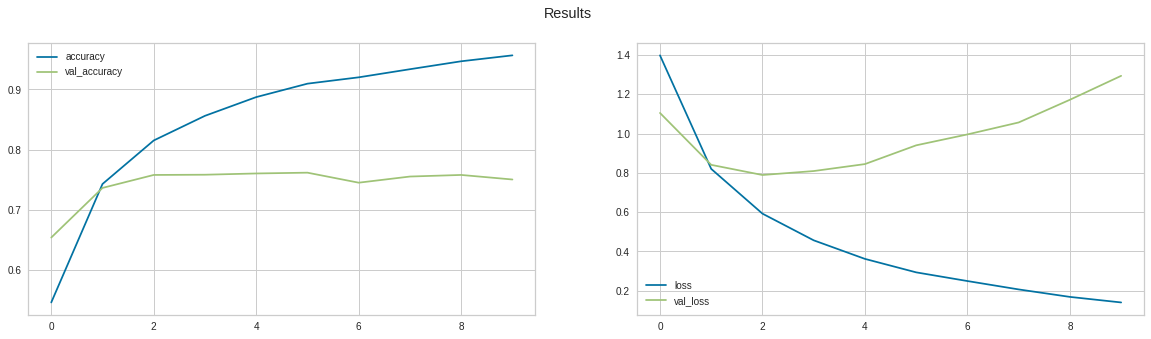

In [ ]:
History = pd.DataFrame(History.history)
# Split the count plot
f, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(20,5))
plt.suptitle('Results')
History[['accuracy', 'val_accuracy']].plot(ax=ax1)
History[['loss', 'val_loss']].plot(ax=ax2)
plt.show()

In [ ]:
# Get the predictions against the test dataset as whole numbers
prediction = model.predict(X_test_RNN)
predicted_class_indices = np.argmax(prediction,axis=-1) 
# Revert the categorical data into ordinal data
y_true = [np.argmax(n) for n in y_test_RNN]
print(classification_report(y_true,predicted_class_indices,target_names=list(oren.categories_[0])))

                             precision    recall  f1-score   support

                Anne Bronte       0.46      0.51      0.49       197
    Bell AKA Bronte Sisters       0.76      0.55      0.64       168
           Charlotte Bronte       1.00      0.48      0.65        25
Edith Rickert & Gleb Botkin       0.61      0.66      0.63        35
               Emily Bronte       0.68      0.68      0.68       371
              Ethel M. Dell       0.80      0.86      0.83      1724
          Fyodor Dostoevsky       0.77      0.79      0.78      1081
             Ivar Jorgensen       0.11      0.07      0.08        15
                Jane Austen       0.74      0.84      0.78       524
                L. T. Meade       0.73      0.67      0.70       533
            S. M. Tenneshaw       0.57      0.52      0.54       181
                    Various       0.80      0.60      0.69       443

                   accuracy                           0.75      5297
                  macro avg     

### **5.3 Model 2**

In [ ]:
model = Sequential()
model.add(Input(shape=(X_train_RNN.shape[1]), name='word_input' ))
model.add(Embedding(5000, 100, input_length=(X_train_RNN.shape[1]), name='word_embed'))
model.add(CuDNNLSTM(64, name='word_lstm'))
model.add(Dense(32, activation='relu', name='word_hidden_1'))
model.add(Dense(32, activation='relu', name='word_hidden_2'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dense(12, activation='softmax', name='output'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_embed (Embedding)       (None, 1497, 100)         500000    
_________________________________________________________________
word_lstm (CuDNNLSTM)        (None, 64)                42496     
_________________________________________________________________
word_hidden_1 (Dense)        (None, 32)                2080      
_________________________________________________________________
word_hidden_2 (Dense)        (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
output (Dense)               (None, 12)               

In [ ]:
History = model.fit(X_train_RNN, y_train_RNN, validation_data = (X_test_RNN, y_test_RNN), batch_size=16, epochs=10)

Epoch 1/10
1325/1325 [==============================] - 229s 168ms/step - loss: 1.7431 - accuracy: 0.3866 - val_loss: 1.3243 - val_accuracy: 0.5601
Epoch 2/10
1325/1325 [==============================] - 222s 168ms/step - loss: 1.1181 - accuracy: 0.6359 - val_loss: 0.9945 - val_accuracy: 0.6876
Epoch 3/10
1325/1325 [==============================] - 242s 182ms/step - loss: 0.8391 - accuracy: 0.7360 - val_loss: 0.9539 - val_accuracy: 0.7051
Epoch 4/10
1325/1325 [==============================] - 225s 170ms/step - loss: 0.6947 - accuracy: 0.7808 - val_loss: 0.9315 - val_accuracy: 0.7151
Epoch 5/10
1325/1325 [==============================] - 223s 168ms/step - loss: 0.5841 - accuracy: 0.8105 - val_loss: 0.9395 - val_accuracy: 0.7200
Epoch 6/10
1325/1325 [==============================] - 221s 167ms/step - loss: 0.4950 - accuracy: 0.8389 - val_loss: 0.9967 - val_accuracy: 0.7306
Epoch 7/10
1325/1325 [==============================] - 221s 167ms/step - loss: 0.4216 - accuracy: 0.8667 - val_

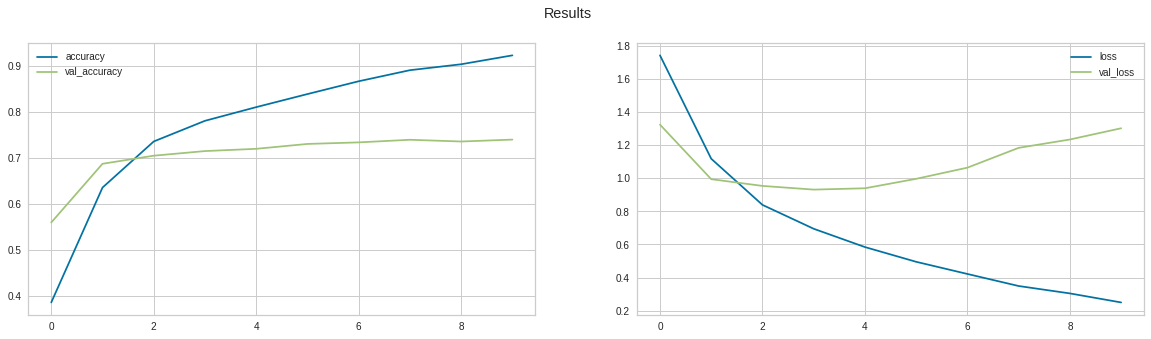

In [ ]:
History = pd.DataFrame(History.history)
# Split the count plot
f, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(20,5))
plt.suptitle('Results')
History[['accuracy', 'val_accuracy']].plot(ax=ax1)
History[['loss', 'val_loss']].plot(ax=ax2)
plt.show()

In [ ]:
# Get the predictions against the test dataset as whole numbers
prediction = model.predict(X_test_RNN)
predicted_class_indices = np.argmax(prediction,axis=-1) 
# Revert the categorical data into ordinal data
y_true = [np.argmax(n) for n in y_test_RNN]
print(classification_report(y_true,predicted_class_indices,target_names=list(oren.categories_[0])))

                             precision    recall  f1-score   support

                Anne Bronte       0.37      0.44      0.40       197
    Bell AKA Bronte Sisters       0.61      0.68      0.64       168
           Charlotte Bronte       0.60      0.36      0.45        25
Edith Rickert & Gleb Botkin       0.44      0.66      0.53        35
               Emily Bronte       0.64      0.65      0.65       371
              Ethel M. Dell       0.84      0.84      0.84      1724
          Fyodor Dostoevsky       0.75      0.79      0.77      1081
             Ivar Jorgensen       0.00      0.00      0.00        15
                Jane Austen       0.83      0.77      0.80       524
                L. T. Meade       0.73      0.66      0.70       533
            S. M. Tenneshaw       0.51      0.49      0.50       181
                    Various       0.70      0.70      0.70       443

                   accuracy                           0.74      5297
                  macro avg     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### **5.4 Model 3**

In [ ]:
model = Sequential()
model.add(Input(shape=(X_train_RNN.shape[1]), name='word_input' ))
model.add(Embedding(5000, 100, input_length=(X_train_RNN.shape[1]), name='word_embed'))
model.add(CuDNNLSTM(64, name='word_lstm'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu', name='word_hidden_1'))
model.add(Dense(32, activation='relu', name='word_hidden_2'))
model.add(Dropout(0.2))
model.add(Dense(12, activation='softmax', name='output'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_embed (Embedding)       (None, 1497, 100)         500000    
_________________________________________________________________
word_lstm (CuDNNLSTM)        (None, 64)                42496     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
word_hidden_1 (Dense)        (None, 64)                4160      
_________________________________________________________________
word_hidden_2 (Dense)        (None, 32)                2080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
output (Dense)               (None, 12)               

In [ ]:
History = model.fit(X_train_RNN, y_train_RNN, validation_data = (X_test_RNN, y_test_RNN), batch_size=16, epochs=10)

Epoch 1/10
1325/1325 [==============================] - 223s 167ms/step - loss: 1.4996 - accuracy: 0.5085 - val_loss: 1.3076 - val_accuracy: 0.5964
Epoch 2/10
1325/1325 [==============================] - 221s 167ms/step - loss: 0.9230 - accuracy: 0.7148 - val_loss: 0.8886 - val_accuracy: 0.7257
Epoch 3/10
1325/1325 [==============================] - 221s 167ms/step - loss: 0.7007 - accuracy: 0.7838 - val_loss: 0.8503 - val_accuracy: 0.7419
Epoch 4/10
1325/1325 [==============================] - 221s 166ms/step - loss: 0.5864 - accuracy: 0.8168 - val_loss: 0.8505 - val_accuracy: 0.7510
Epoch 5/10
1325/1325 [==============================] - 222s 168ms/step - loss: 0.4933 - accuracy: 0.8496 - val_loss: 0.8885 - val_accuracy: 0.7618
Epoch 6/10
1325/1325 [==============================] - 222s 168ms/step - loss: 0.4056 - accuracy: 0.8769 - val_loss: 0.9255 - val_accuracy: 0.7625
Epoch 7/10
1325/1325 [==============================] - 223s 168ms/step - loss: 0.3467 - accuracy: 0.8963 - val_

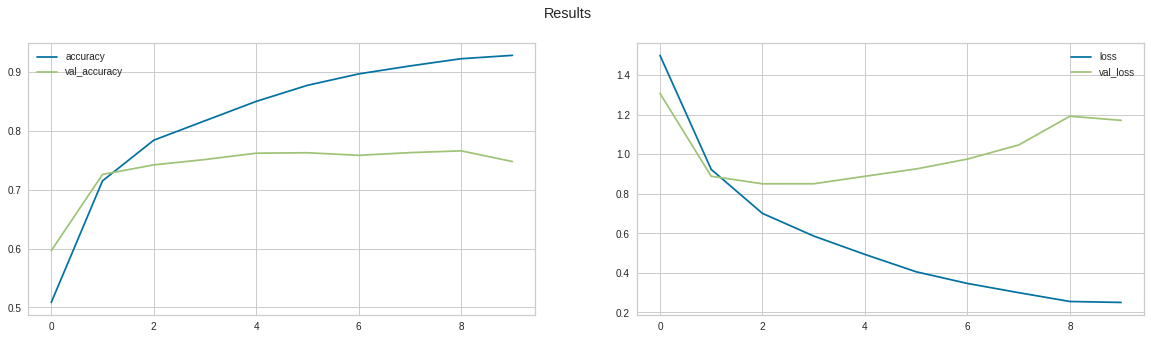

In [ ]:
History = pd.DataFrame(History.history)
# Split the count plot
f, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(20,5))
plt.suptitle('Results')
History[['accuracy', 'val_accuracy']].plot(ax=ax1)
History[['loss', 'val_loss']].plot(ax=ax2)
plt.show()

In [ ]:
# Get the predictions against the test dataset as whole numbers
prediction = model.predict(X_test_RNN)
predicted_class_indices = np.argmax(prediction,axis=-1) 
# Revert the categorical data into ordinal data
y_true = [np.argmax(n) for n in y_test_RNN]
print(classification_report(y_true,predicted_class_indices,target_names=list(oren.categories_[0])))

                             precision    recall  f1-score   support

                Anne Bronte       0.44      0.42      0.43       197
    Bell AKA Bronte Sisters       0.62      0.75      0.68       168
           Charlotte Bronte       0.55      0.48      0.51        25
Edith Rickert & Gleb Botkin       0.67      0.57      0.62        35
               Emily Bronte       0.66      0.74      0.70       371
              Ethel M. Dell       0.85      0.81      0.83      1724
          Fyodor Dostoevsky       0.74      0.81      0.77      1081
             Ivar Jorgensen       0.00      0.00      0.00        15
                Jane Austen       0.77      0.81      0.79       524
                L. T. Meade       0.74      0.66      0.70       533
            S. M. Tenneshaw       0.63      0.49      0.55       181
                    Various       0.69      0.71      0.70       443

                   accuracy                           0.75      5297
                  macro avg     

### **5.4 Conclusion**

> RNN model is good for this classification project.

> Tuning the model reduces overfitting. 

> The accuracy of the models is high in the train set, but only about 0.75 in the test set.



---


## **6. Unsupervised Technique** 

### **6.1 K - Means**

In [ ]:
# Bag of Words Vector
vectorizer = CountVectorizer(analyzer='word')
vectorized = vectorizer.fit_transform(novels['lemmatized'].astype(str))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fc1a40d8990>,
                 k=None, metric=None, model=None, timings=True)

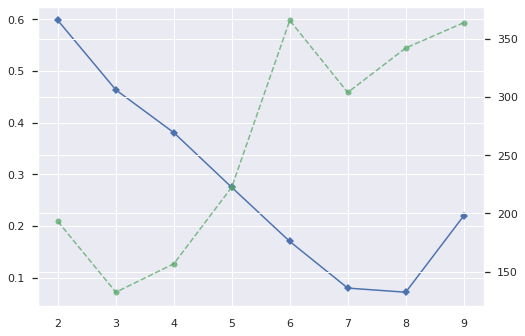

In [ ]:
# Elbow Method for choosing number of cluster
K_Means_Model = KMeans(n_clusters=5)
clusters_KMeans = K_Means_Model.fit_predict(vectorized)
visualizer = KElbowVisualizer(K_Means_Model, k=(2,10), metric='silhouette')
visualizer.fit(vectorized)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fc19f470310>,
                     model=None)

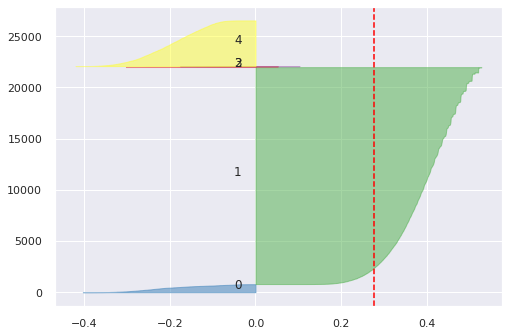

In [ ]:
# Declare and fit the model 
K_Means_Model = KMeans(n_clusters = 5, random_state=10)
visualizer = SilhouetteVisualizer(K_Means_Model, colors='yellowbrick')
visualizer.fit(vectorized) # Fit the data to the visualizer

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


InterclusterDistance(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fc19f4ffe10>,
                     embedding='mds', legend=True, legend_loc='lower left',
                     legend_size=1.5, max_size=25000, min_size=400, model=None,
                     random_state=None, scoring='membership')

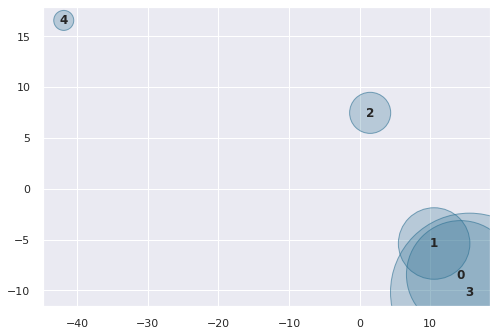

In [ ]:
# Distance visualizer on five clusters
K_Means_Model = KMeans(n_clusters=5)
visualizer = InterclusterDistance(K_Means_Model)
visualizer.fit(vectorized)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


InterclusterDistance(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fc19fcf7a10>,
                     embedding='mds', legend=True, legend_loc='lower left',
                     legend_size=1.5, max_size=25000, min_size=400, model=None,
                     random_state=None, scoring='membership')

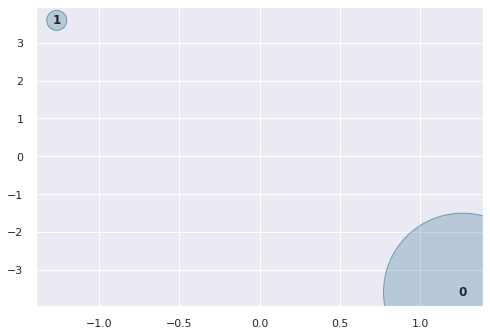

In [ ]:
# Distance visualizer on two clusters
K_Means_Model = KMeans(n_clusters=2)
visualizer = InterclusterDistance(K_Means_Model)
visualizer.fit(vectorized)

In [ ]:
# Fit on two clusters
K_Means_Model = KMeans(n_clusters = 2)
clusters_KMeans = K_Means_Model.fit_predict(vectorized)
novels['KMeanBow'] = clusters_KMeans
novels[['KMeanBow', 'author']].groupby(by='KMeanBow').describe()

author                                
          count unique                top  freq
KMeanBow                                       
0         25460     12      Ethel M. Dell  8523
1          1025      9  Fyodor Dostoevsky   469

In [ ]:
novels[['KMeanBow', 'author']].groupby(by='KMeanBow')['author'].value_counts()

KMeanBow  author                     
0         Ethel M. Dell                  8527
          Fyodor Dostoevsky              5056
          L. T. Meade                    2548
          Jane Austen                    2426
          Various                        2167
          Emily Bronte                   1840
          Bell AKA Bronte Sisters         876
          S. M. Tenneshaw                 856
          Anne Bronte                     827
          Edith Rickert & Gleb Botkin     191
          Charlotte Bronte                 93
          Ivar Jorgensen                   75
1         Fyodor Dostoevsky               461
          Jane Austen                     230
          Anne Bronte                      95
          Ethel M. Dell                    94
          Emily Bronte                     76
          L. T. Meade                      15
          Charlotte Bronte                 13
          Various                          12
          Bell AKA Bronte Sisters         

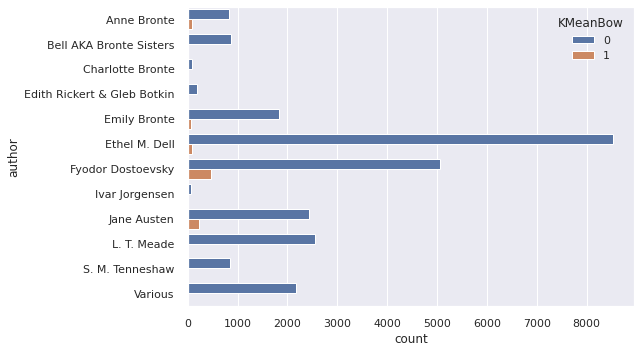

In [ ]:
ax = sns.countplot(y='author', data=novels[['KMeanBow', 'author']], hue='KMeanBow')

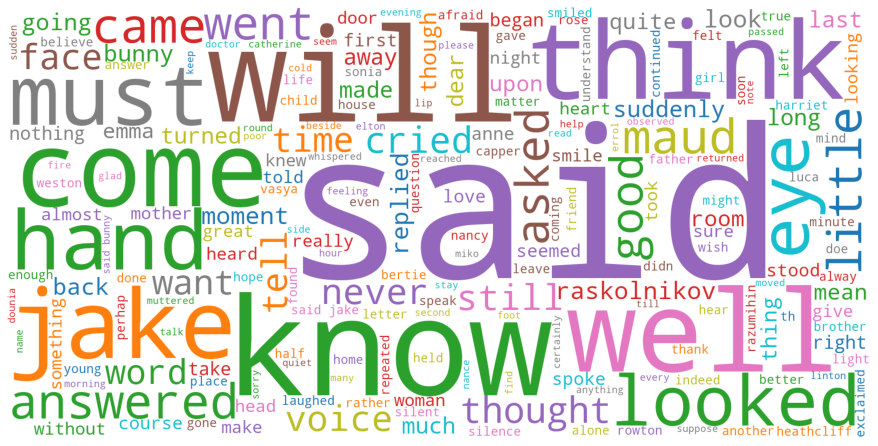

In [ ]:
def Word_Cloud(text, colormap='tab10', background_color='white'):
  cloud = WordCloud(width=1600, height=800,stopwords=STOPWORDS,colormap=colormap,background_color=background_color).generate(text)
  plt.figure(figsize=(12,10))
  plt.imshow(cloud)
  plt.axis("off")
  plt.tight_layout(pad=0)
  plt.show()
document = novels[novels.KMeanBow == 0]['lemmatized'].str.join(sep=' ')
Word_Cloud(document.to_string())

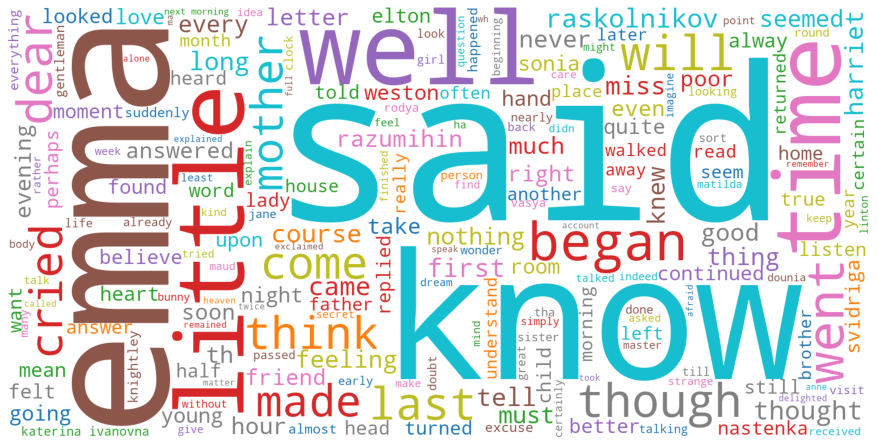

In [ ]:
document = novels[novels.KMeanBow == 1]['lemmatized'].str.join(sep=' ')
Word_Cloud(document.to_string())

In [ ]:
novels.to_parquet(path='/content/drive/MyDrive/Data/Author Classification/Novels_KMeans/Novels_KMean.parquet')

### **6.2 Agglomerative**

In [ ]:
Agg_model = AgglomerativeClustering(n_clusters=5)
novels['AggBow'] = Agg_model.fit_predict(vectorized.toarray())
clusters_Agg = novels['AggBow'] 
novels[['AggBow', 'author']].groupby(by='AggBow').describe()
print(metrics.silhouette_score(vectorized, clusters_Agg.labels_))

In [ ]:
Agg_model = AgglomerativeClustering(n_clusters=2)
novels['AggBow'] = Agg_model.fit_predict(vectorized.toarray())
clusters_Agg = novels['AggBow'] 
novels[['AggBow', 'author']].groupby(by='AggBow').describe()
print(metrics.silhouette_score(vectorized, clusters_Agg.labels_))

### **6.3 Gaussian Mixture**

In [ ]:
GauMixture_cluster = GaussianMixture(n_components=2, random_state=13, covariance_type='full')
clusters_GauMixture = GauMixture_cluster.fit_predict(vectorized.toarray())
novels['GMBow'] = clusters_GauMixture
print("The silhoutte score of the Gaussian Mixture solution: {}".format(metrics.silhouette_score(vectorized.toarray(), clusters_GauMixture)))

### **6.4 Conclusion**

>  K-Means has the best resource to offer with regards to telling a story with the data.



---


## **7. Latent Dirichlet Allocation, Latent Semantic Analysis, Non-Negative Matrix Factorization** 

### **7.1 Latent Semantic Analysis**

In [ ]:
# file location
PATH = '/content/drive/MyDrive/Data/Author Classification/Novels_KMeans/Novels_KMean.parquet'
novels = pd.read_parquet(PATH)
novels

,sentence,author,tokenized,lemmatized,KMeanBow
0,Agnes Grey NOVEL,Anne Bronte,"[agnes, grey, novel]","[agnes, grey, novel]",0
4,Illustration Birthplace Charlotte Emily Anne B...,Anne Bronte,"[illustration, birthplace, charlotte, emily, a...","[illustration, birthplace, charlotte, emily, a...",0
8,true histories contain instruction though some...,Anne Bronte,"[true, histories, contain, instruction, though...","[true, history, contain, instruction, though, ...",0
9,father clergyman north England deservedly resp...,Anne Bronte,"[father, clergyman, north, england, deservedly...","[father, clergyman, north, england, deservedly...",0
10,Finding arguments avail father length told lov...,Anne Bronte,"[finding, arguments, avail, father, length, to...","[finding, argument, avail, father, length, tol...",0
...,...,...,...,...,...
2452,Dear Editor,Various,"[dear, editor]","[dear, editor]",0
2453,have read first copy Astounding Stories think ...,Various,"[have, read, first, copy, astounding, stories,...","[have, read, first, copy, astounding, story, t...",0
2454,Congratulations,Various,[congratulations],[congratulation],0
2455,Dear Editor,Various,"[dear, editor]","[dear, editor]",0


In [ ]:
# Number of Keywords and Topics for each model
num_keywords = 10
num_topics = 10

In [ ]:
# Bag of Words Vector
vectorizer_one = TfidfVectorizer()
vectorized_one = vectorizer_one.fit_transform(novels[novels.KMeanBow ==1]['lemmatized'].astype(str))
vectorizer_zero = TfidfVectorizer()
vectorized_zero= vectorizer_zero.fit_transform(novels[novels.KMeanBow ==0]['lemmatized'].astype(str))

In [ ]:
model_LSA = TruncatedSVD(n_components=num_topics)
model_LSA.fit_transform(vectorized_one.toarray())

results = [[(vectorizer_one.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-num_keywords - 1:-1]] for topic in model_LSA.components_]
one = [[x[0] for x in i] for i in results]
# This format for readability
for topic in one:
  print(*topic)

that have with they would what will were from could
your will that know what have tell come shall yourself
they ivanovitch semyon ivanovna were went them face raskolnikov into
they their will them your shall themselves were these donell
ivanovna katerina sonia amalia them their child raskolnikov table they
ivanovna ivanovitch katerina semyon amalia sonia vasya lodger arkady very
your jane said miss room came here door shall very
would they come said knew jane came went sure here
your would ivanovitch semyon should have linton heathcliff father catherine
will vasya arkady love shall would ivanovna mother come said


In [ ]:
# Redfine the model so it's not tainted by the first one
model_LSA = TruncatedSVD(n_components=num_topics)
model_LSA.fit_transform(vectorized_zero.toarray())

results = [[(vectorizer_zero.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-num_keywords - 1:-1]] for topic in model_LSA.components_]
zero = [[x[0] for x in i] for i in results]
# This format for readability
for topic in zero:
  print(*topic)

said that what have with will your know there very
said jake bunny lucas maud anne bertie capper think want
what asked mean matter know cried tell want doing doe
have will your know well come shall think must tell
that know jake would could knew mean only told should
will know that come tell your then well want jake
know jake asked have your bunny with here maud come
know well very think good about were they much there
asked well very your where rowton said they going lady
jake well very think will with bunny good have quite


### **7.2 Latent Dirichlet Allocation**

In [ ]:
#Bag of Words Vector
vectorizer_one = CountVectorizer()
vectorized_one = vectorizer_one.fit_transform(novels[novels.KMeanBow ==1]['lemmatized'].astype(str))
vectorizer_zero = CountVectorizer()
vectorized_zero= vectorizer_zero.fit_transform(novels[novels.KMeanBow ==0]['lemmatized'].astype(str))

In [ ]:
model_LDA = LatentDirichletAllocation(n_components=num_topics, learning_method='online')
model_LDA.fit_transform(vectorized_one.toarray())

results = [[(vectorizer_one.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-num_keywords - 1:-1]] for topic in model_LDA.components_]
one = [[x[0] for x in i] for i in results]

#This format for readability. 
for topic in one:
  print(*topic)

thou thee maria labour tomorrow toil meltham appears thine canst
nikolaitch fedosey list opposition osip error mihailitch radio burr logical
emma miss harriet jane very with knightley weston elton much
moan toothache scheme dared greville decease guest vale realm innocently
that with have would they from were what there them
will like have story conversation matter author marvel their future
which this with donell they sophia amiable father lesley mountain
ustinya elderly intelligible shumkov promontory groom rock amazing weed yulian
fork knife stipulation forcibly beefsteak potato acquirement lizanka spectator tumbled
cipher obeyed temple shadow forcing photograph hieroglyphic outside forever suffice


In [ ]:
model_LDA = LatentDirichletAllocation(n_components=num_topics, learning_method='online')
model_LDA.fit_transform(vectorized_zero.toarray())
results = [[(vectorizer_zero.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-num_keywords - 1:-1]] for topic in model_LDA.components_]
zero = [[x[0] for x in i] for i in results]

#This format for readability. 
for topic in zero:
  print(*topic)

with eye hand face turned looked suddenly upon that back
spoke silence miko first kleig anita moyen strength grantline human
said that what know with have jake never tell will
will have your come said here there that they this
that love could such even would than more life those
what want your that lady have said cried sort know
down letter from side minute vasya into began looking fell
that with from were they which room into there went
light jane over slowly john later body long their wild
have that very with would been emma miss much could


### **7.3 Non-Negative Matrix Factorization**

In [ ]:
# Bag of Words Vector
vectorizer_one = TfidfVectorizer()
vectorized_one = vectorizer_one.fit_transform(novels[novels.KMeanBow ==1]['lemmatized'].astype(str))
vectorizer_zero = TfidfVectorizer()
vectorized_zero= vectorizer_zero.fit_transform(novels[novels.KMeanBow ==0]['lemmatized'].astype(str))

In [ ]:
model_NMF = NMF(n_components=num_topics)
model_NMF.fit_transform(vectorized_one.toarray())

results = [[(vectorizer_one.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-num_keywords - 1:-1]] for topic in model_NMF.components_]
one = [[x[0] for x in i] for i in results]

#This format for readability. 
for topic in one:
  print(*topic)

that what know even love only with like perhaps fact
will have shall know come what tell love there this
harriet emma very jane elton knightley been miss weston could
they them their were themselves people would sonia each these
ivanovitch semyon vasya arkady that prohartchin mark yulian mastakovitch lodger
ivanovna katerina sonia amalia that table lodger raskolnikov herself child
with were into there room face went hand down door
which with from mother that this father lady than more
would that have could knew should again might then back
your have yourself that what here know rouble said should


In [ ]:
model_NMF = NMF(n_components=num_topics)
model_NMF.fit_transform(vectorized_zero.toarray())

results = [[(vectorizer_zero.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-num_keywords - 1:-1]] for topic in model_NMF.components_]
zero = [[x[0] for x in i] for i in results]

#This format for readability. 
for topic in zero:
  print(*topic)

with from were they there eye then hand into face
said again lucas anne bertie voice think want rowton nance
what mean matter cried want tell about doing this happened
have been would must this your never should could done
that like would only could never knew should thing more
will your come tell shall here take when think this
jake bunny maud right bolton going hand silent reckon smiled
know want about didn tell really like think only where
asked where going raskolnikov here rowton doe nancy suddenly want
well very think good much miss quite emma dear must


### **7.4 Conclusion**

> The LDA model seems to have the most information regarding the top ten topics for each cluster.